# 0. Import libraries and load Data

Install required Python packages using pip package manager

In [1]:
!pip install pandas -q          # pandas: provides data manipulation and analysis tools
!pip install numpy -q           # numpy: provides support for numerical operations
!pip install matplotlib -q      # matplotlib: provides data visualization tools
!pip install seaborn -q         # seaborn: provides advanced data visualization tools
!pip install scikit-learn -q    # scikit-learn: provides machine learning algorithms
!pip install scipy -q           # scipy: provides scientific computing functions


Import required Python libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import math
import seaborn as sns
from matplotlib import colors

reads the 'csv' files and store the data in DataFrames

In [12]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
poi_df = pd.read_csv('data/poi.csv')

/tmp/ipykernel_6758/4245473066.py:3: DtypeWarning: Columns (7,9,11,13,17,18,19,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,74,77,80,82,83,84,85,86,87,90,91,92,95) have mixed types. Specify dtype option on import or set low_memory=False.
  poi_df = pd.read_csv('data/poi.csv')


# 1. Data Preparing

# 1.0. Utilities Functions

In [13]:
def NaN_analysis(df):
    """
    Computes two types of analyses on the input pandas DataFrame:
    
    1. Percentage of NaN values in each column, sorted in descending order of percentage.
    2. Number of rows with a specific number of NaN values, up to the total number of columns in the input DataFrame.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The DataFrame to be analyzed.
    
    Returns:
    --------
    analysis1 : pandas DataFrame
        The percentage of NaN values in each column, sorted in descending order of percentage.
    analysis2 : pandas DataFrame
        The number of rows with a specific number of NaN values, up to the total number of columns in the input DataFrame.
    """
    # analysis1: percentage of NaN values in columns
    d = {'column': [], 'n_nan': [], 'percentage': []}
    for col in df.columns:
        n_nan = df[(df[col].isna()) | (df[col].isnull())].shape[0]
        d['column'].append(col)
        d['n_nan'].append(n_nan)
        d['percentage'].append((n_nan*100)/df.shape[0])
    analysis1 = pd.DataFrame(d).sort_values('percentage', ascending=False).reset_index(drop=True)
    # analysis2: number of NaN values in each row grouped by number of NaN values
    d = {'n_nan': [], 'n_rows': []}
    for n_nan in range(1, df.shape[1]+1):
        n_rows = df[df.isna().sum(axis=1) == n_nan].shape[0]
        d['n_nan'].append(n_nan)
        d['n_rows'].append(n_rows)
    analysis2 = pd.DataFrame(d).sort_values('n_nan', ascending=False).reset_index(drop=True)
    return analysis1, analysis2

In [28]:
def groupby_count_percentage(df, col):
    tmp = df[col].to_frame().copy()
    tmp.fillna('NaN', inplace=True)
    tmp['count'] = 0
    tmp = tmp.groupby(col).count().reset_index().sort_values('count', ascending=False).reset_index(drop=True)
    tmp['percentage'] = (tmp['count']*100)/df.shape[0]
    return tmp

In [49]:
def hist_subplot(df, feature, b=100):
    df = df.dropna(subset=[feature]).reset_index(drop=True) #before plotting we remove the NaNs otherwise it will not be possible to plot the graphs 
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axs[0].hist(df[feature], bins=b)
    axs[0].set_title('Histogram distribution of {}'.format(feature))
    axs[0].set_ylabel('Count')
    axs[0].set_xlabel('Value')
    axs[1].hist2d(pd.Series(np.array([i for i in range(df.loc[:, feature].shape[0])])), df.loc[:, feature], bins=b, norm=colors.LogNorm())
    axs[1].set_title('2D histogram distribution of {}'.format(feature))
    axs[1].set_ylabel('Value')
    axs[1].set_xlabel('Index')
    plt.tight_layout()
    plt.show()
    return

# 1.1. Point of Interest Analysis

In [14]:
poi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397382 entries, 0 to 397381
Data columns (total 96 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id_on_platform         397382 non-null  int64  
 1   lat                    397382 non-null  float64
 2   lon                    397382 non-null  float64
 3   source                 397382 non-null  object 
 4   tags.addr:city         80929 non-null   object 
 5   tags.addr:country      32852 non-null   object 
 6   tags.addr:housenumber  104548 non-null  object 
 7   tags.addr:postcode     64669 non-null   object 
 8   tags.addr:street       97486 non-null   object 
 9   tags.alt_name:gl       1 non-null       object 
 10  tags.amenity           50459 non-null   object 
 11  tags.artwork_type      662 non-null     object 
 12  tags.barrier           42890 non-null   object 
 13  tags.bicycle           3878 non-null    object 
 14  tags.brand             4342 non-null

Performiamo la NaN analysis su poi_df

In [15]:
analysis1, analysis2 = NaN_analysis(poi_df)

In [16]:
analysis1

,column,n_nan,percentage
0,tags.alt_name:gl,397381,99.999748
1,tags.source:name:oc,397381,99.999748
2,tags.name:east2276,397381,99.999748
3,tags.name:za,397381,99.999748
4,tags.ref:ISTAT,397380,99.999497
...,...,...,...
91,tags.addr:housenumber,292834,73.690806
92,lon,0,0.000000
93,source,0,0.000000
94,lat,0,0.000000


In [17]:
analysis2

,n_nan,n_rows
0,96,0
1,95,0
2,94,0
3,93,0
4,92,106013
...,...,...
91,5,0
92,4,0
93,3,0
94,2,0


notiamo che la maggior parte delle colonne contengono NaN. Ci limiteremo ad utilizzare unicamente le colonne lat, lon per aggiungere eventuali features

In [5]:
poi_df = poi_df.filter(['lat', 'lon'])

Plottando lo scatterplot delle coordinate possiamo notare la distribuzione dei punti di interesse

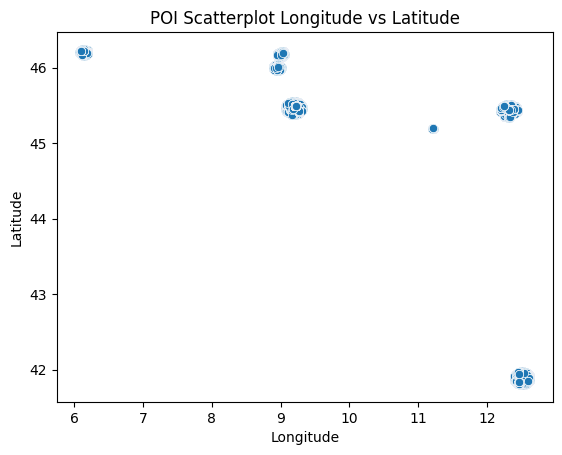

In [6]:
sns.scatterplot(x='lon', y='lat', data=poi_df)
plt.title('POI Scatterplot Longitude vs Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

# 1.2. Train Dataset Analysis

Droppiamo la colonna id da train_df, cosi da lasciare in train_df solo le colonne delle features e la colonna delle predictions

In [18]:
# drop id
train_df.drop('id', axis=1, inplace=True)

Performiamo la NaN analysis su train_df

In [19]:
analysis1, analysis2 = NaN_analysis(train_df)

In [20]:
analysis1

,column,n_nan,percentage
0,garden,31529,68.079547
1,energy_efficiency,19903,42.975903
2,total_floors,18349,39.620401
3,elevator,17443,37.664104
4,expenses,16154,34.880808
5,balcony,15443,33.345569
6,construction_year,13946,30.113146
7,n_bathrooms,2416,5.216790
8,floor,2031,4.385472
9,conditions,1229,2.653740


In [21]:
analysis2

,n_nan,n_rows
0,16,0
1,15,0
2,14,0
3,13,0
4,12,1
5,11,3
6,10,172
7,9,147
8,8,536
9,7,1295


# 1.3. Add Features

Aggiungiamo la feature n_poi

In [22]:
def get_n_poi(lat, lon, poi_df, radius=0.001):
    if math.isnan(lat) or math.isnan(lon):
        return np.nan
    # get all poi in a certain radius from the current lat and lon
    series = poi_df[(poi_df['lat']-lat)**2 + (poi_df['lon']-lon)**2 <= radius**2]
    # n_poi = np.nan if series.shape[0] == 0 else series.shape[0]
    return series.shape[0] # n_poi

In [23]:
train_df['n_poi'] = train_df.apply(lambda x: get_n_poi(x['latitude'], x['longitude'], poi_df), axis=1)

Aggiungiamo la feature ratio

In [24]:
def lambda_ratio(x):
    n_room = x['n_rooms']
    n_bathroom = x['n_bathrooms']
    if not math.isnan(n_room) and not math.isnan(n_bathroom):
        return n_room/max(1, n_bathroom) 
    else:
        return np.nan

In [25]:
train_df['ratio'] = train_df.apply(lambda x: lambda_ratio(x), axis=1)

Aggiungiamo la feature m2_per_bathrooms

In [26]:
def lambda_m2_per_bathrooms(x):
    n_room = x['n_rooms']
    n_bathroom = x['n_bathrooms']
    m2 = x['surface']
    if not math.isnan(n_bathroom) and not math.isnan(m2):
        return m2/max(1, n_room*3 + n_bathroom)
    else:
        return np.nan

In [27]:
train_df['m2_per_bathrooms'] = train_df.apply(lambda x: lambda_m2_per_bathrooms(x), axis=1)

# 1.4. Fill NaNs

We can notice that for the features balcony and garden the NaN are actually 'False'. So we replace NaN with False

In [29]:
groupby_count_percentage(train_df, 'balcony')

,balcony,count,percentage
0,True,30869,66.654431
1,NaN,15443,33.345569


In [30]:
groupby_count_percentage(train_df, 'garden')

,garden,count,percentage
0,NaN,31529,68.079547
1,True,14783,31.920453


In [31]:
train_df['garden'] = train_df['garden'].fillna(False)
train_df['balcony'] = train_df['balcony'].fillna(False)

We encode garden, balcony and condition. In order to have for each feature only int or float as data, in this way we can plot graphs to better understand what to do with the NaN if drop or fix them. 
\
We have to point out that we encode condition with the assumption that also the test data will have the same labels as the train data for the feature condition.

In [32]:
train_df['garden'] = train_df['garden'].apply(lambda x: 1 if x == True else 0)
train_df['balcony'] = train_df['balcony'].apply(lambda x: 1 if x == True else 0)

Trasformiamo anche la feature categorica 'conditions' in una features numerica

In [33]:
map_conditions = {}
index = 0
for value in train_df['conditions'].unique():
    if value not in map_conditions:
        map_conditions[value] = index
        index += 1
map_conditions

{'Buono stato / Abitabile': 0,
 'Ottimo / Ristrutturato': 1,
 'Da ristrutturare': 2,
 'Nuovo / Nuova costruzione': 3,
 nan: 4}

In [34]:
train_df['conditions'] = train_df['conditions'].apply(lambda x: map_conditions[x])
train_df['conditions'] = train_df['conditions'].apply(lambda x: np.nan if x == map_conditions[np.nan] else x)

For each column that has at least a NaN as a data we plot the histogram distribution also in 2D

In [35]:
columns_wnan = []
for col in train_df.columns:
    if train_df[train_df[col].isna()].shape[0] > 0:
        columns_wnan.append(col)
columns_wnan

['conditions',
 'construction_year',
 'latitude',
 'longitude',
 'energy_efficiency',
 'expenses',
 'floor',
 'n_bathrooms',
 'elevator',
 'total_floors',
 'n_rooms',
 'proximity_to_center',
 'surface',
 'n_poi',
 'ratio',
 'm2_per_bathrooms']

plottando gli istogrammi delle features con i NaN notiamo che ci sono abbastanza saples distribuiti, non NaN, che possono permetterci di fillare i NaN con tecniche apposite.

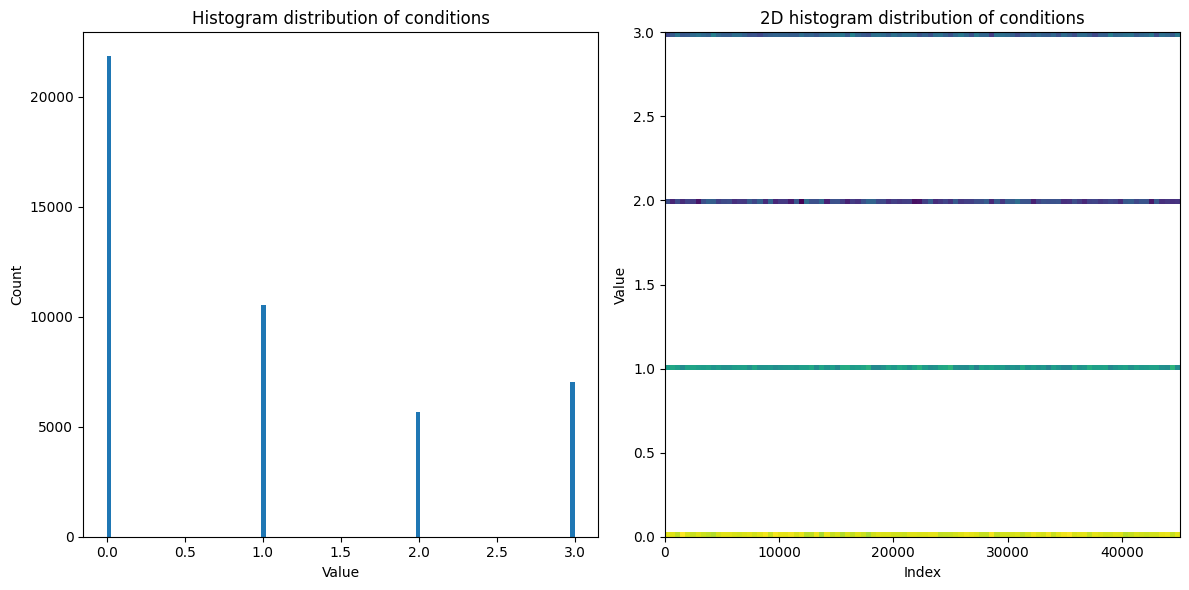

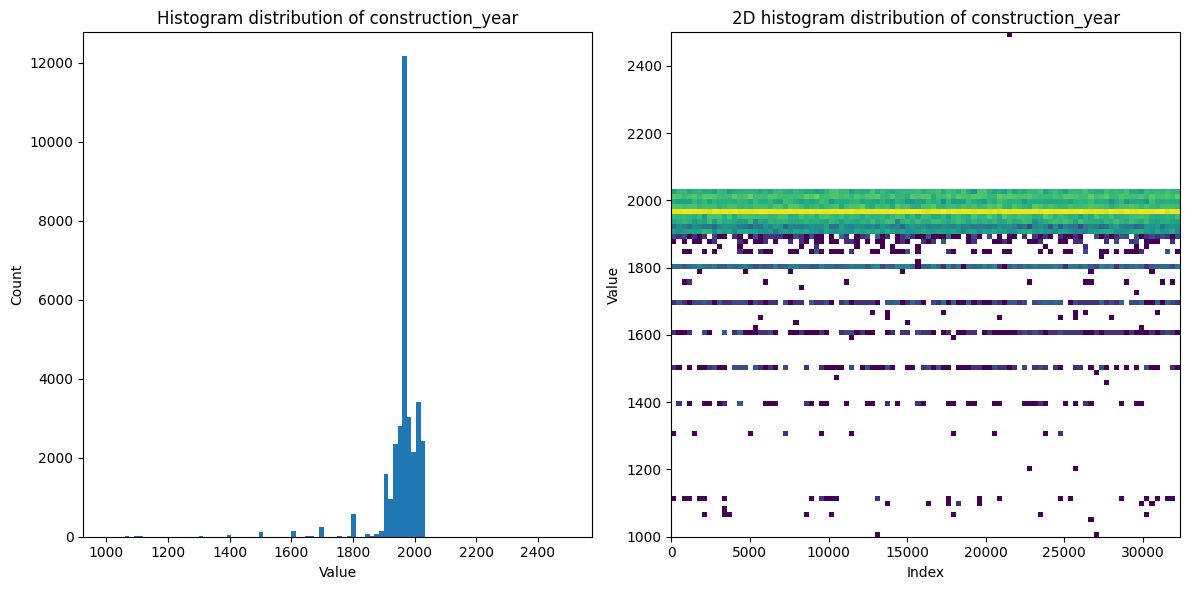

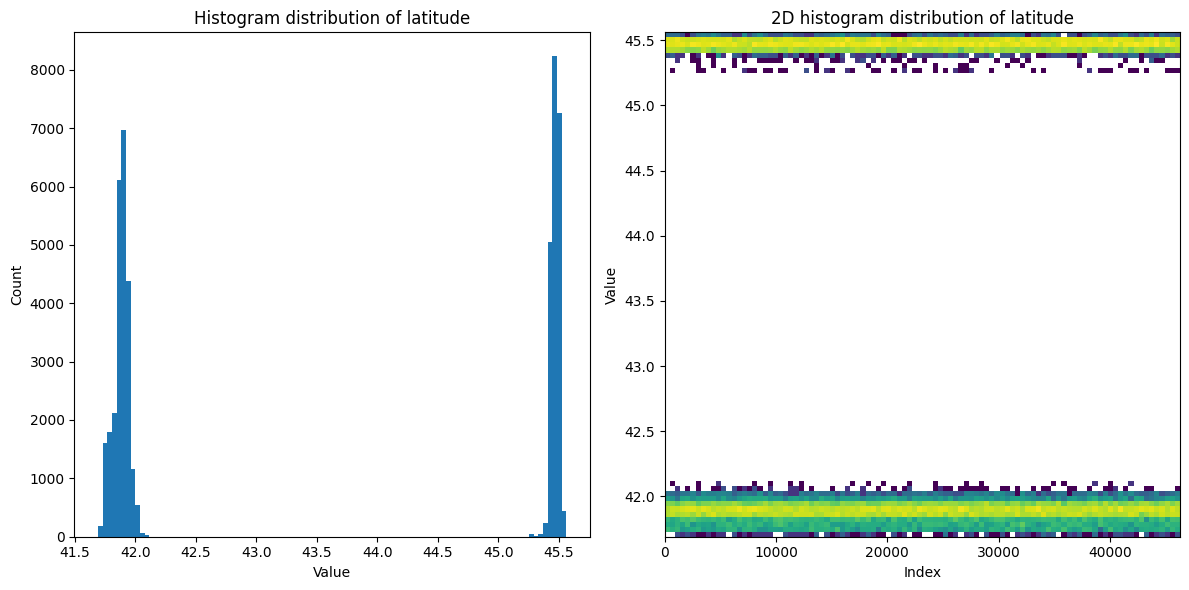

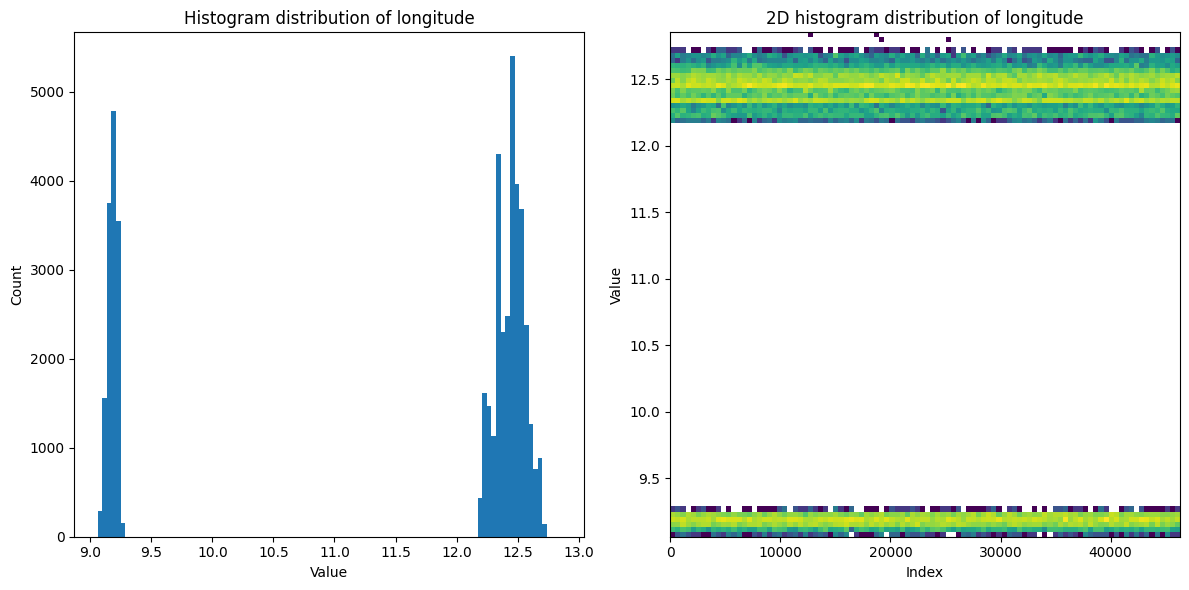

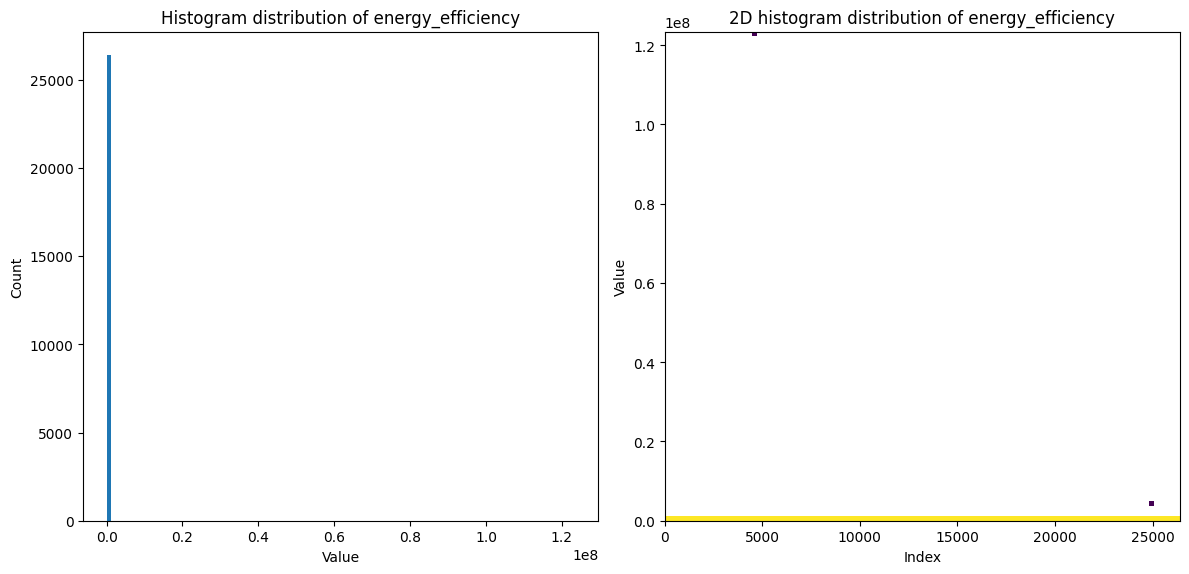

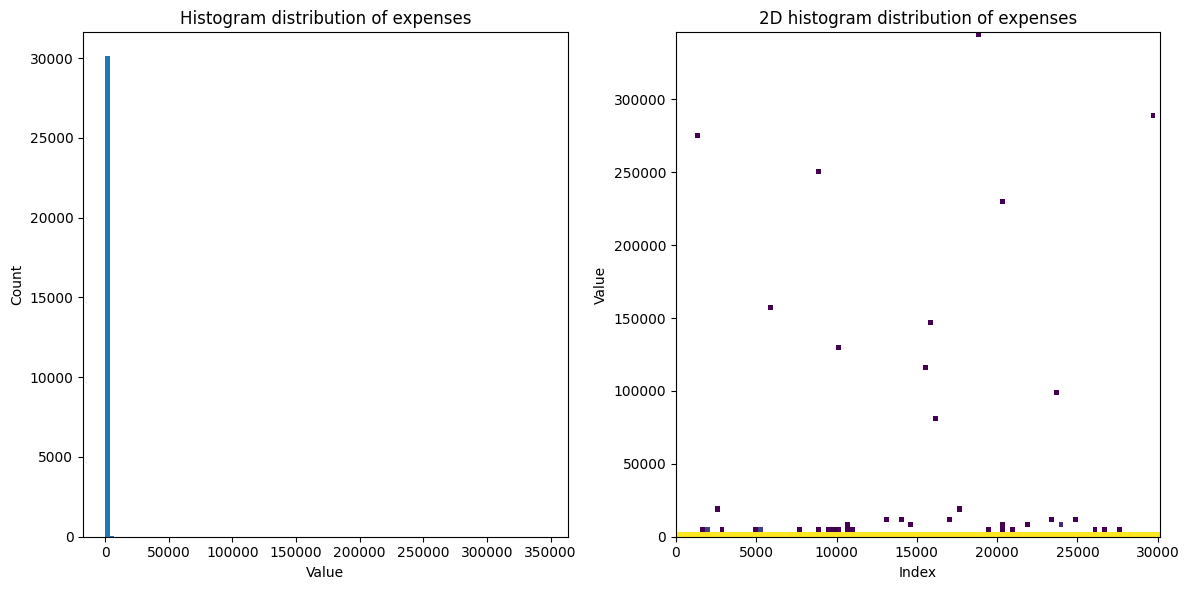

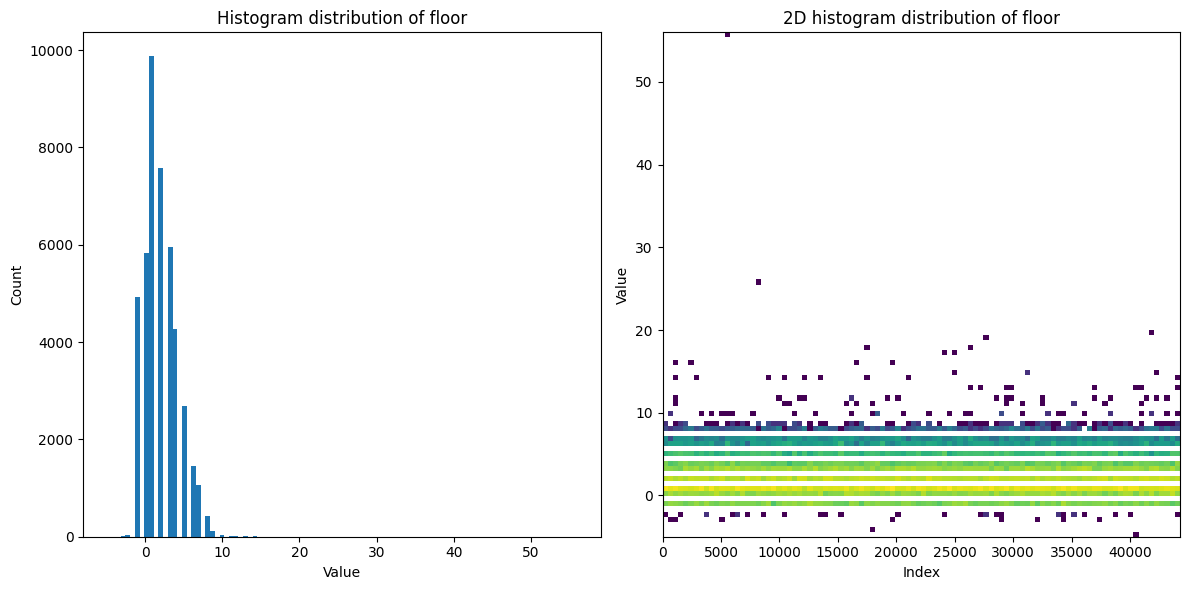

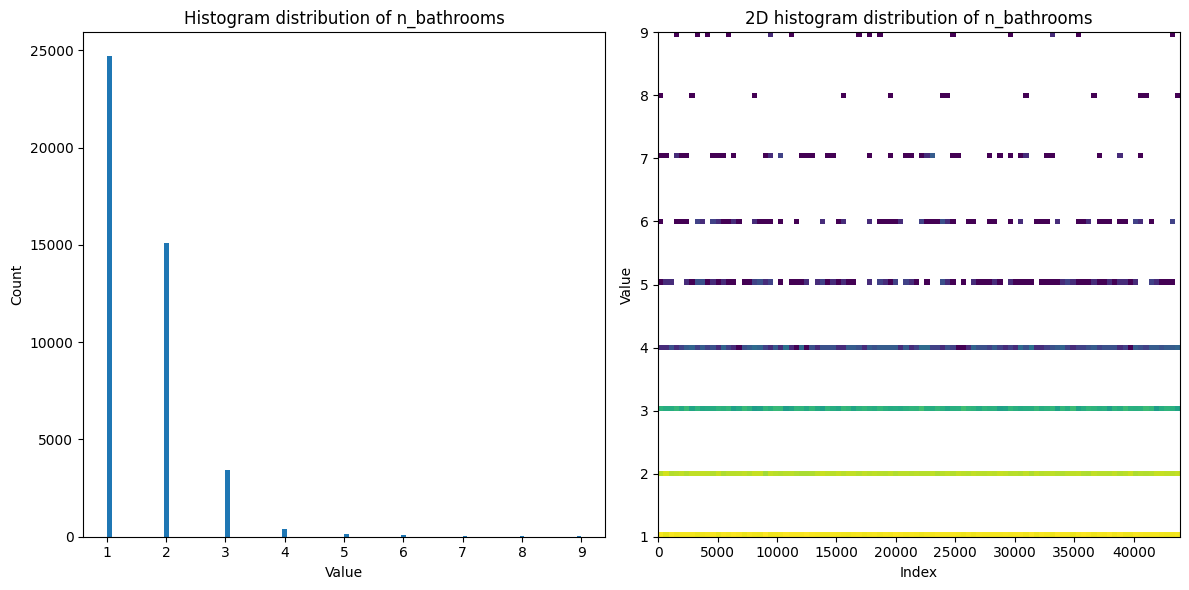

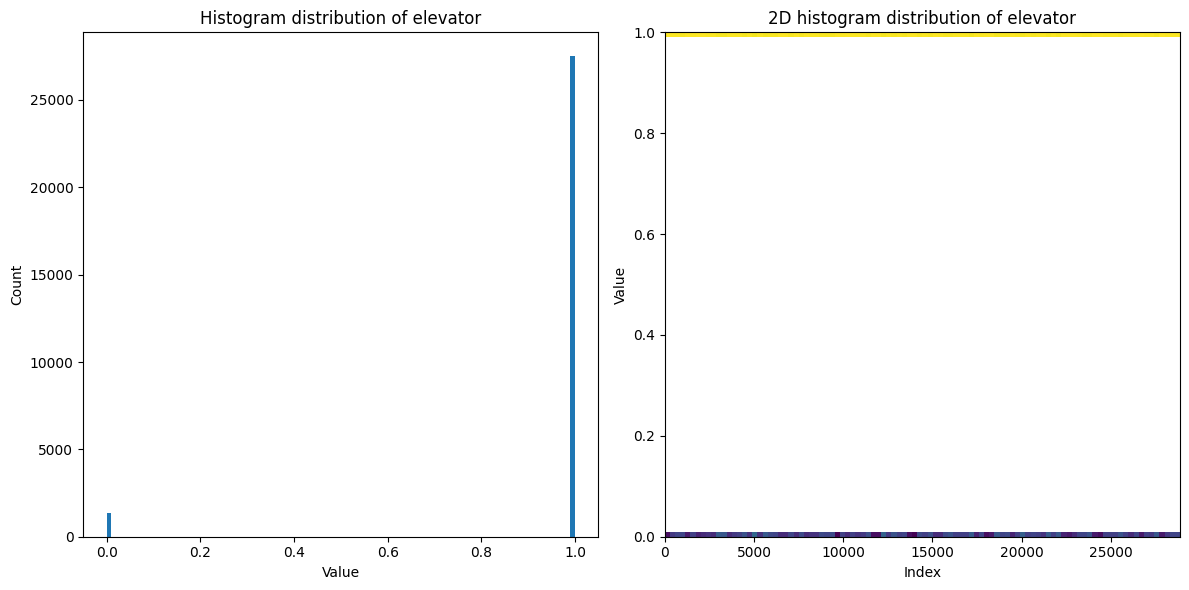

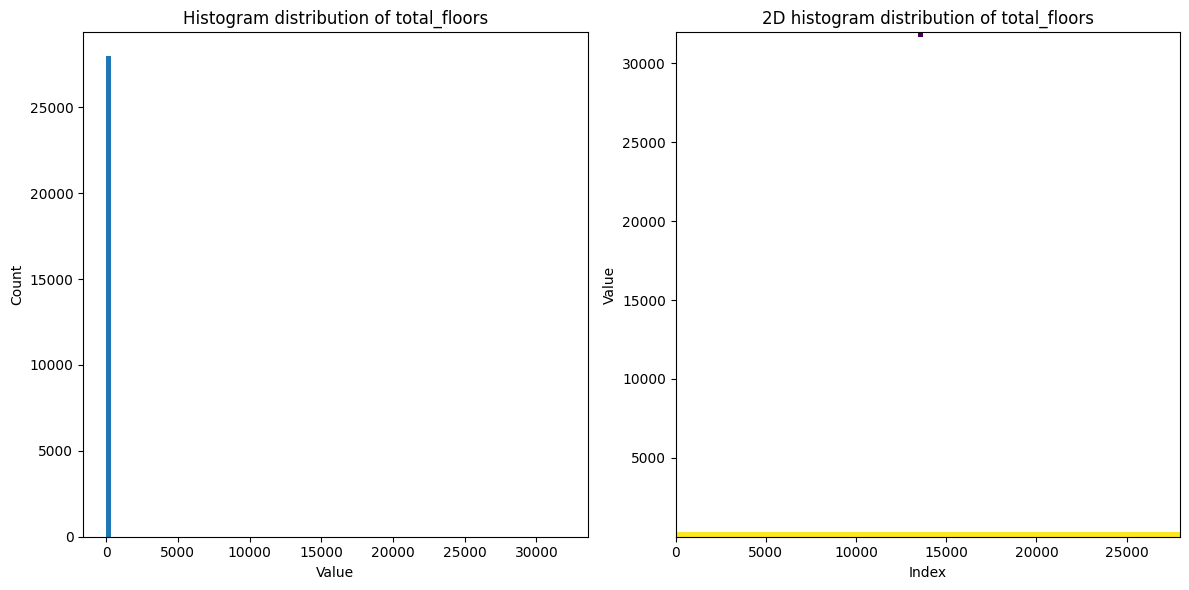

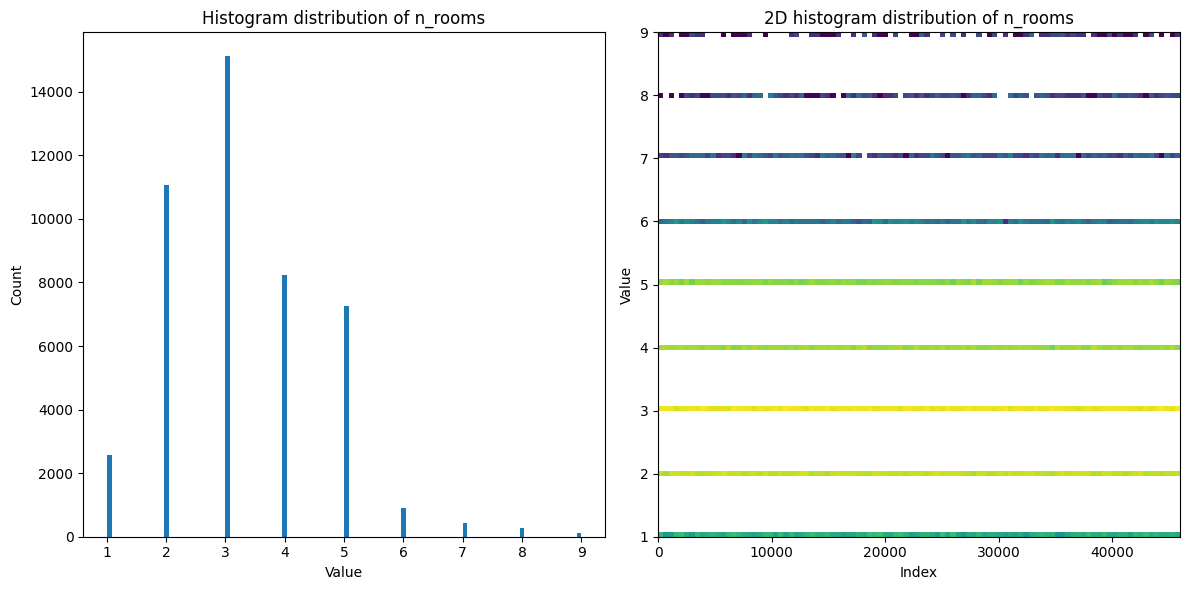

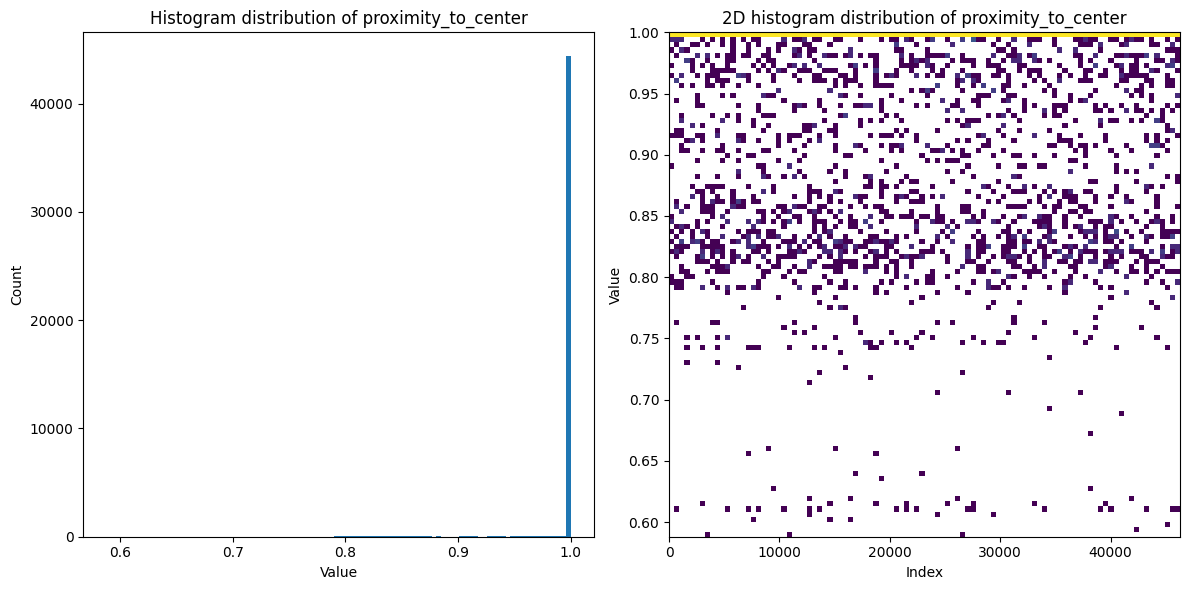

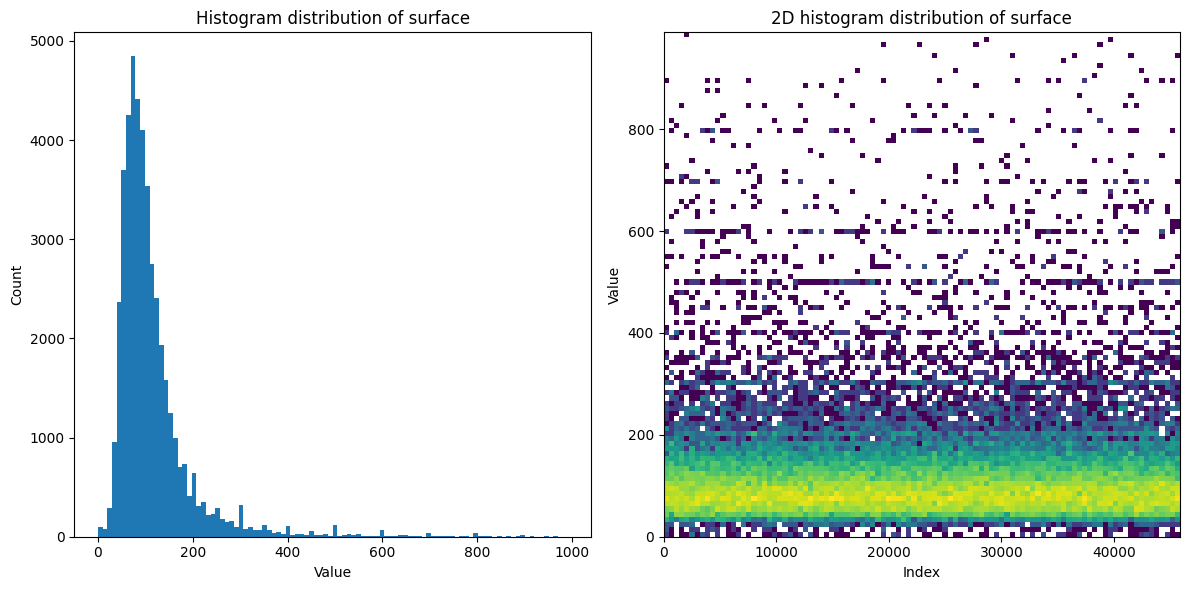

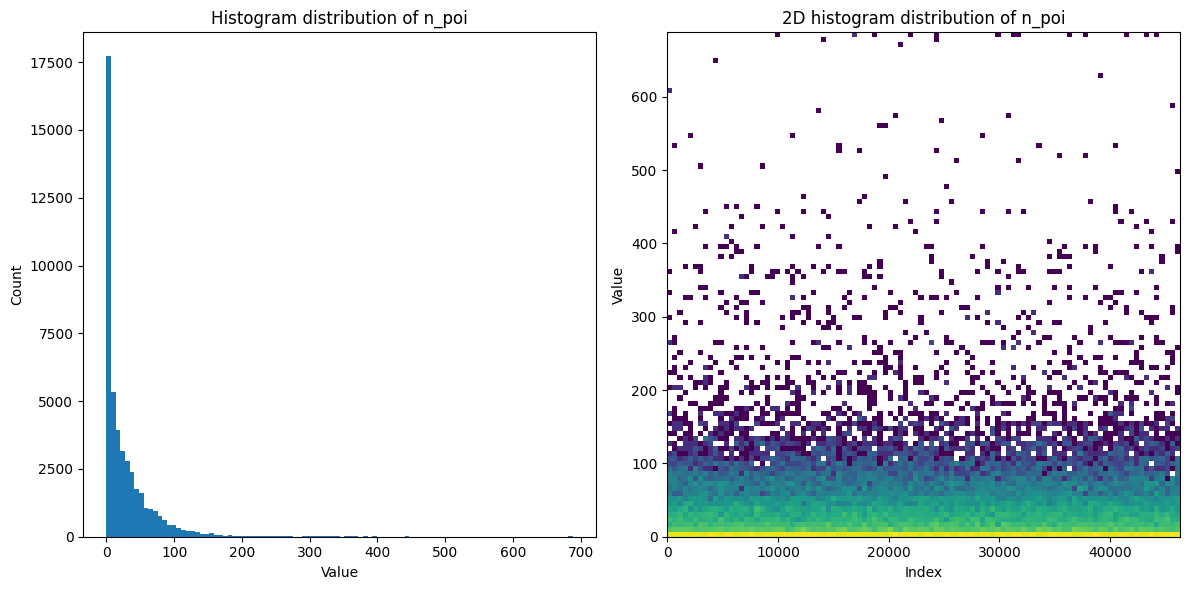

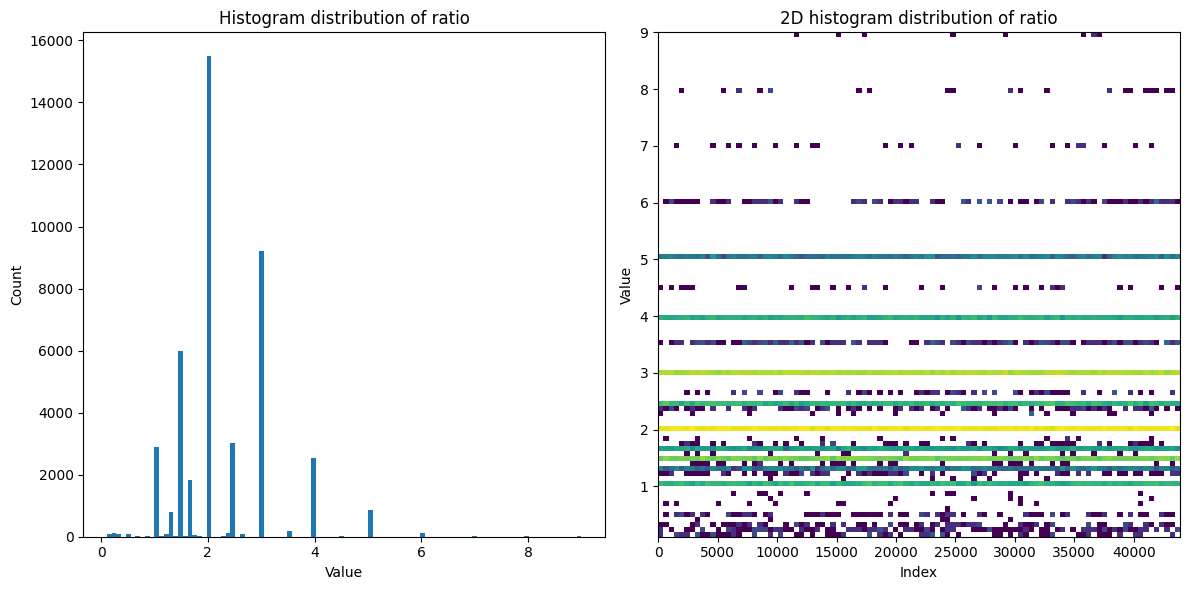

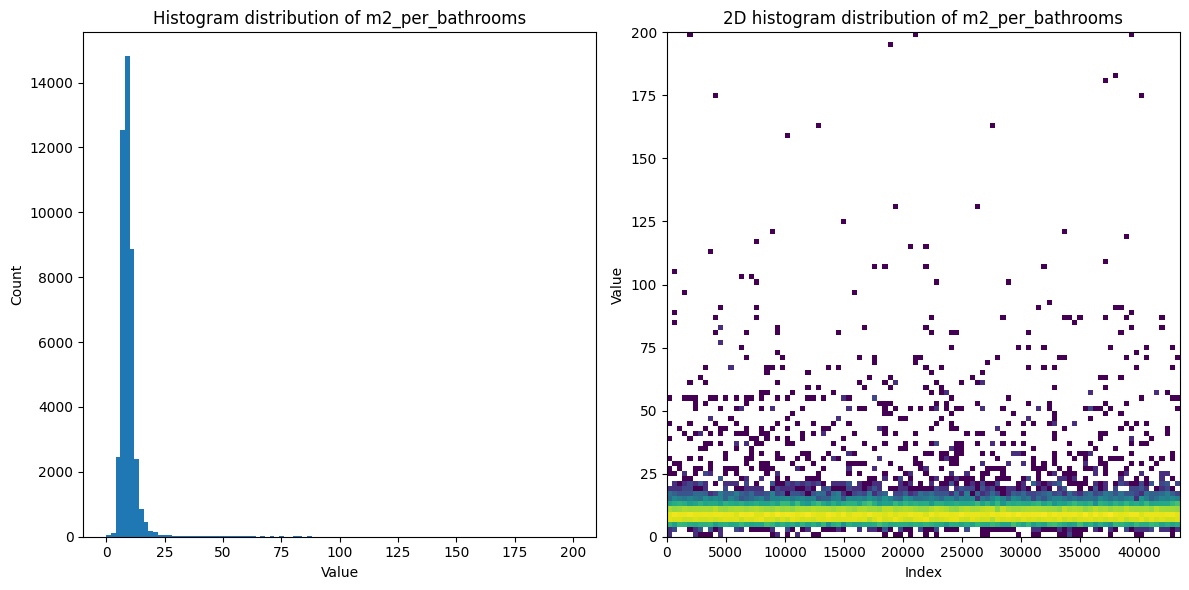

In [50]:
for col in columns_wnan:
    hist_subplot(train_df, col)

# 2. Data Processing

In questa sezione processiamo i dati per poter procedere poi al training dei modelli. L'obiettivo in questa sezione è di processare al meglio i dati per renderli al meglio digeribili dai supervised models

# 2.1. Data Transformation

PLottiamo prima delle trasformation, gli hist per ogni colonna di train_df

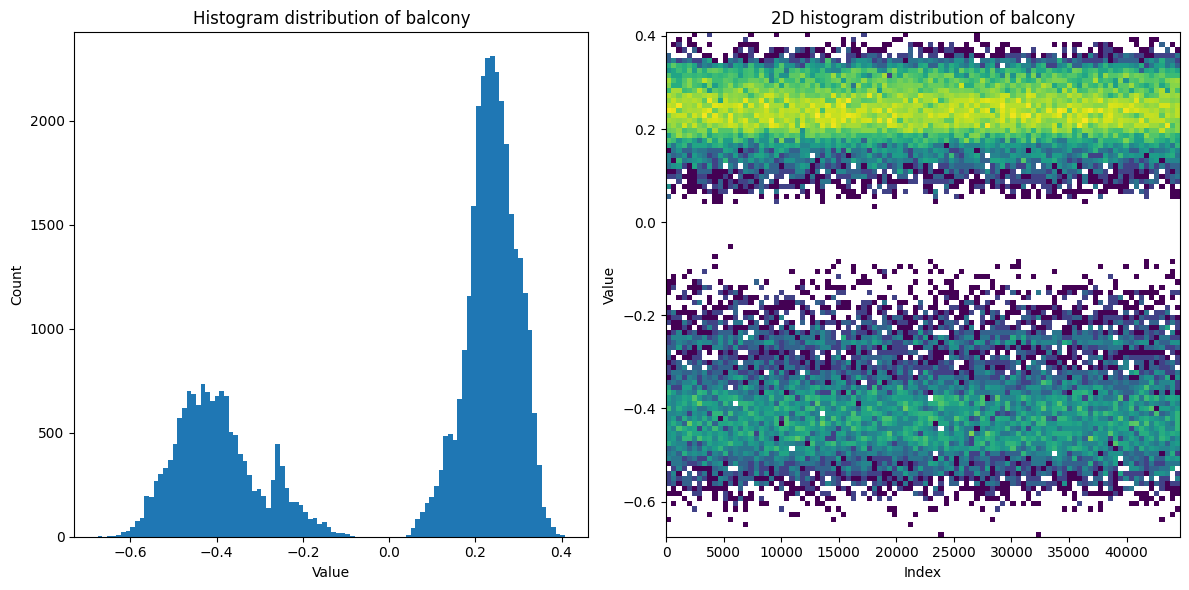

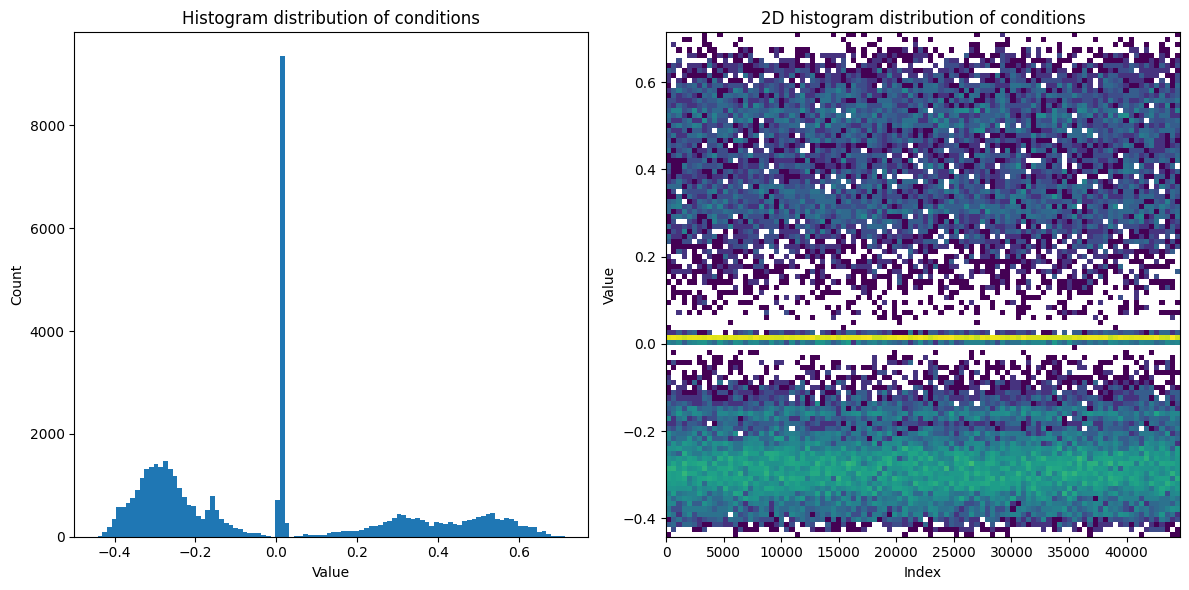

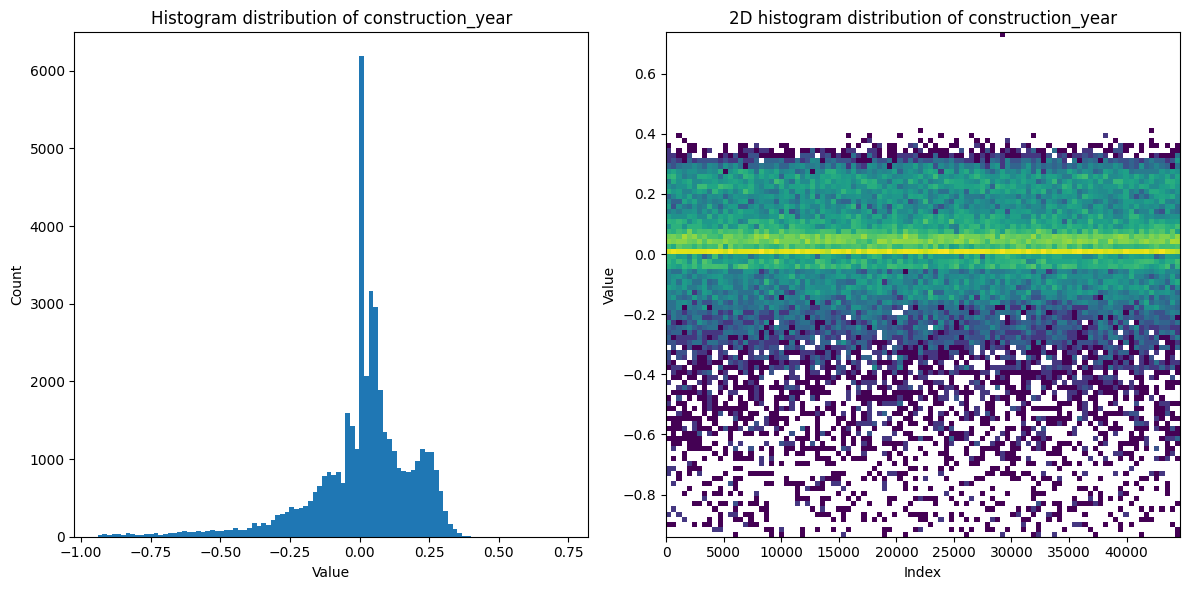

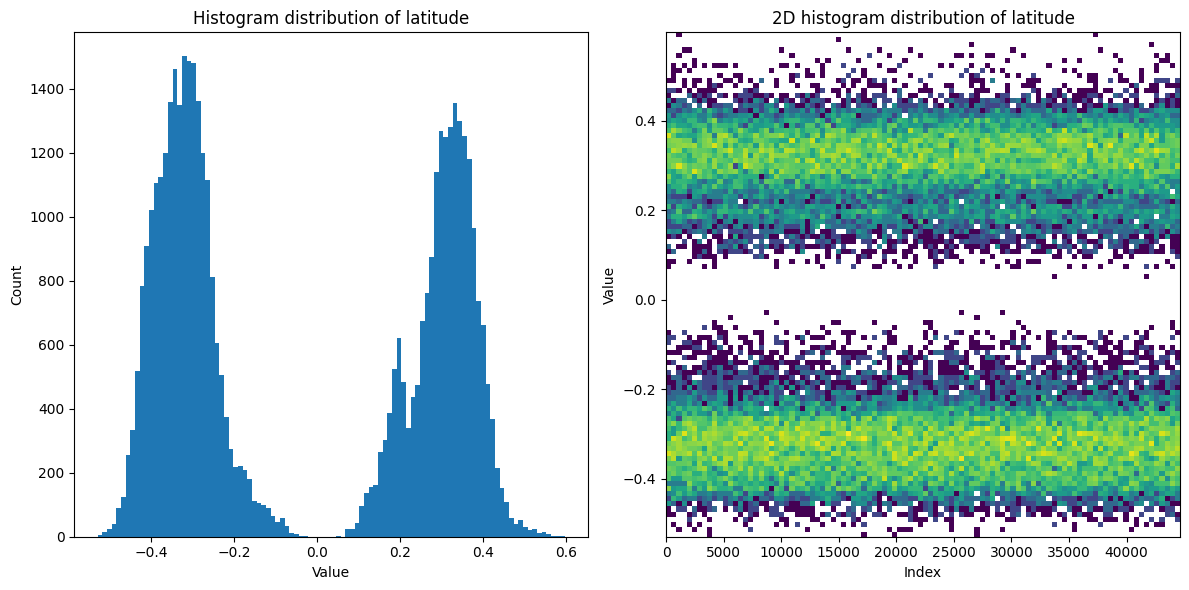

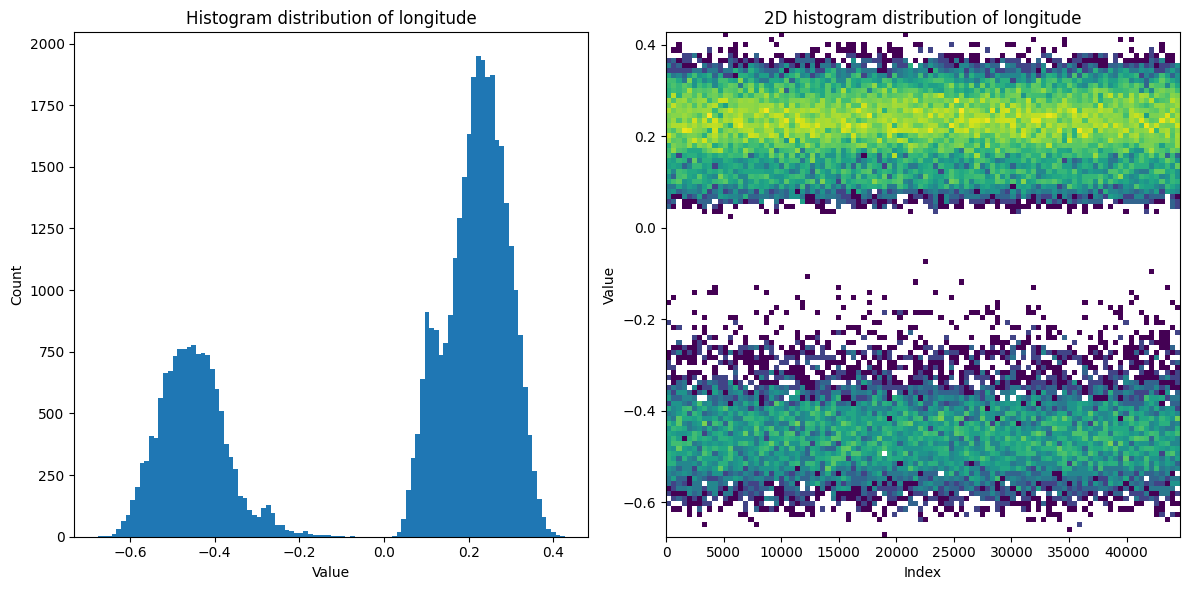

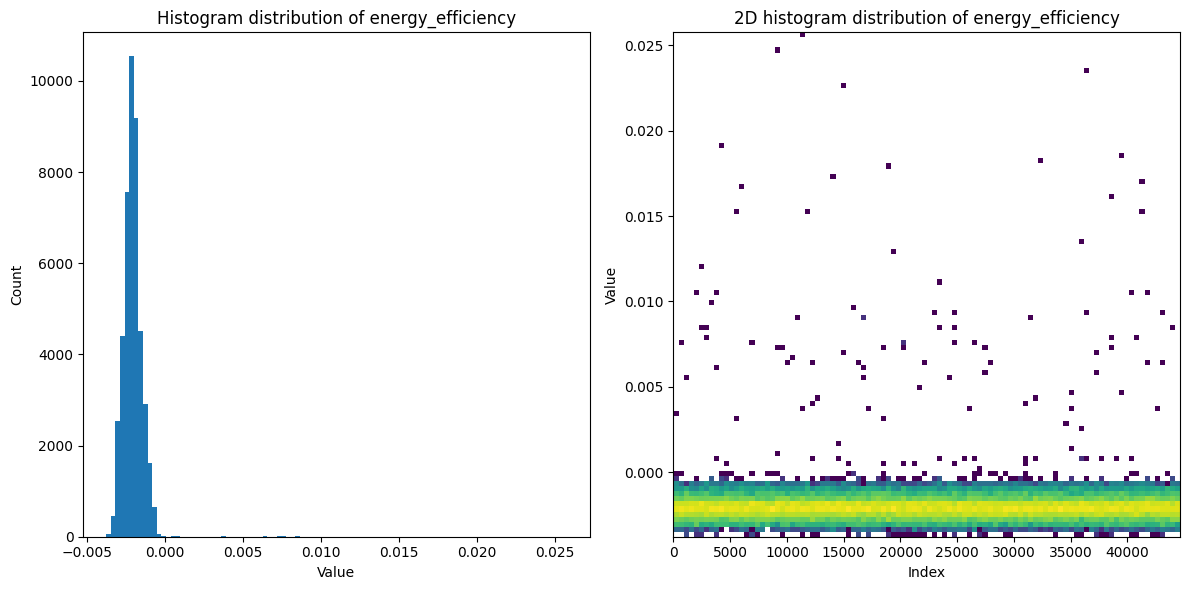

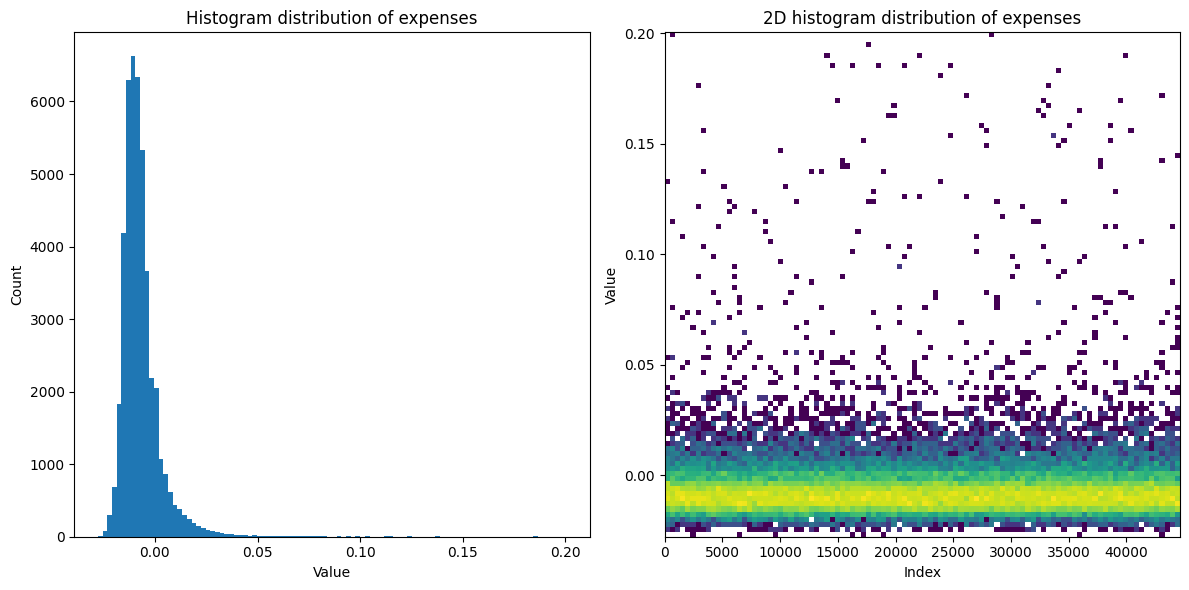

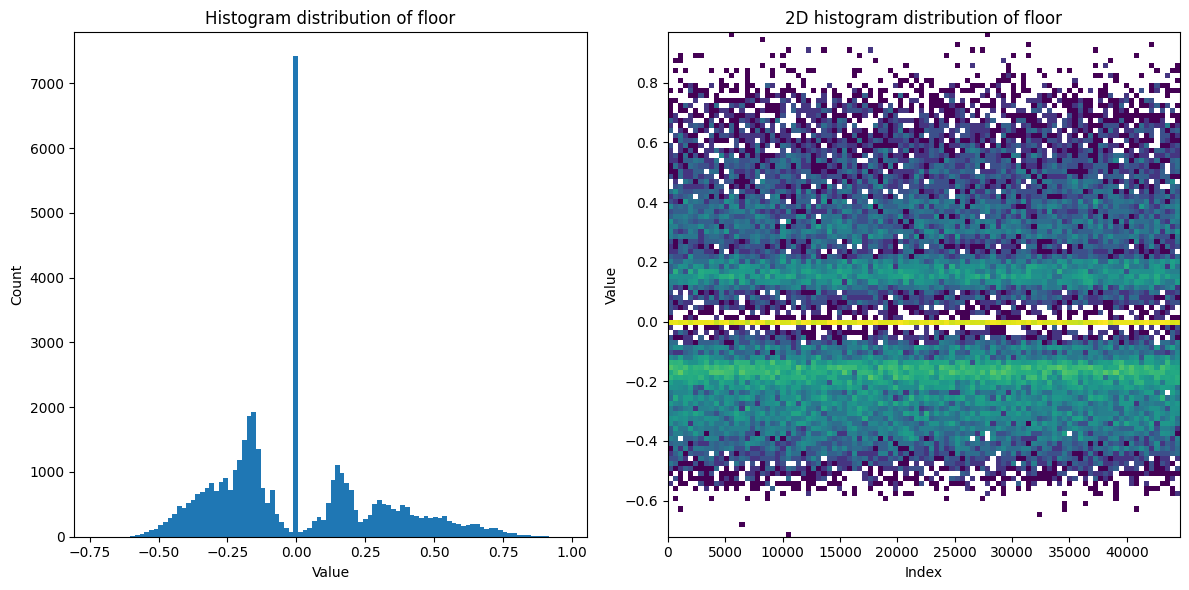

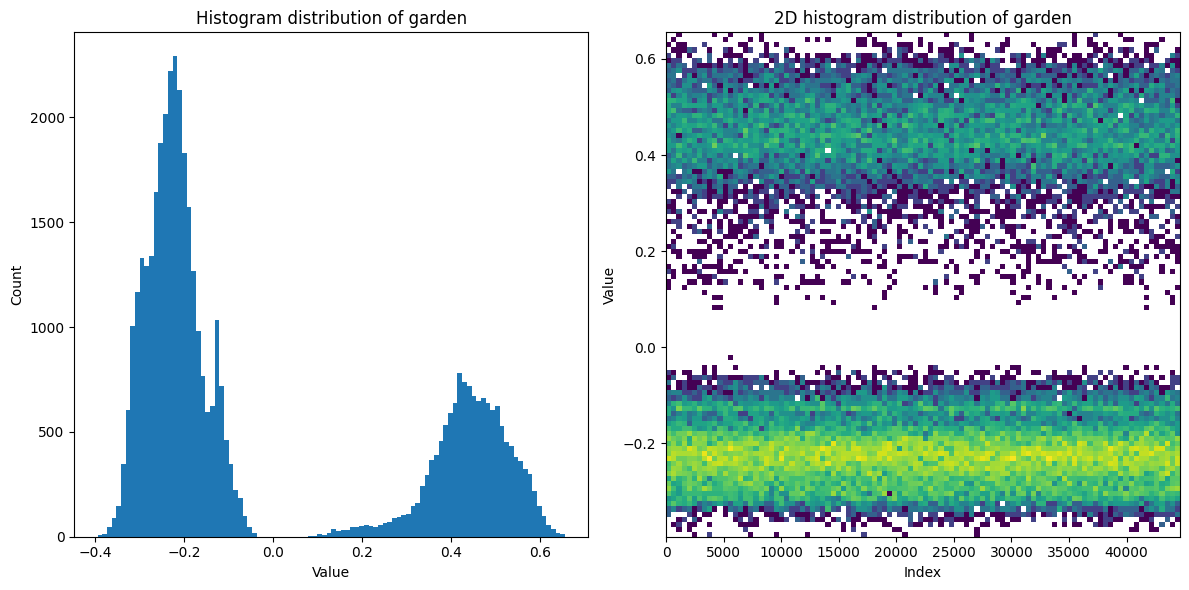

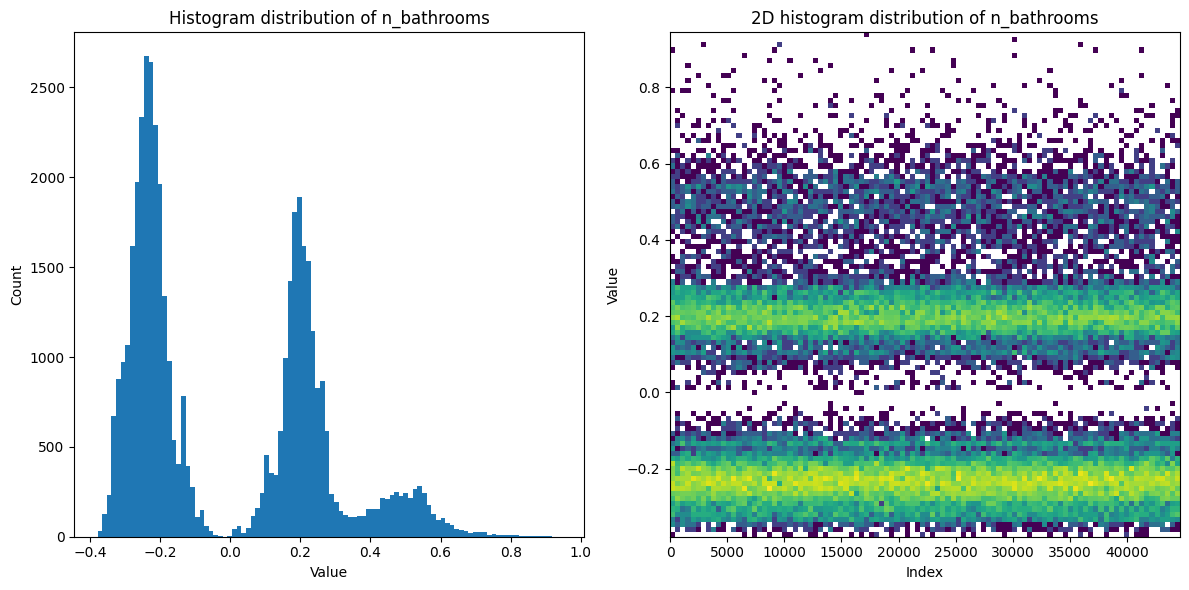

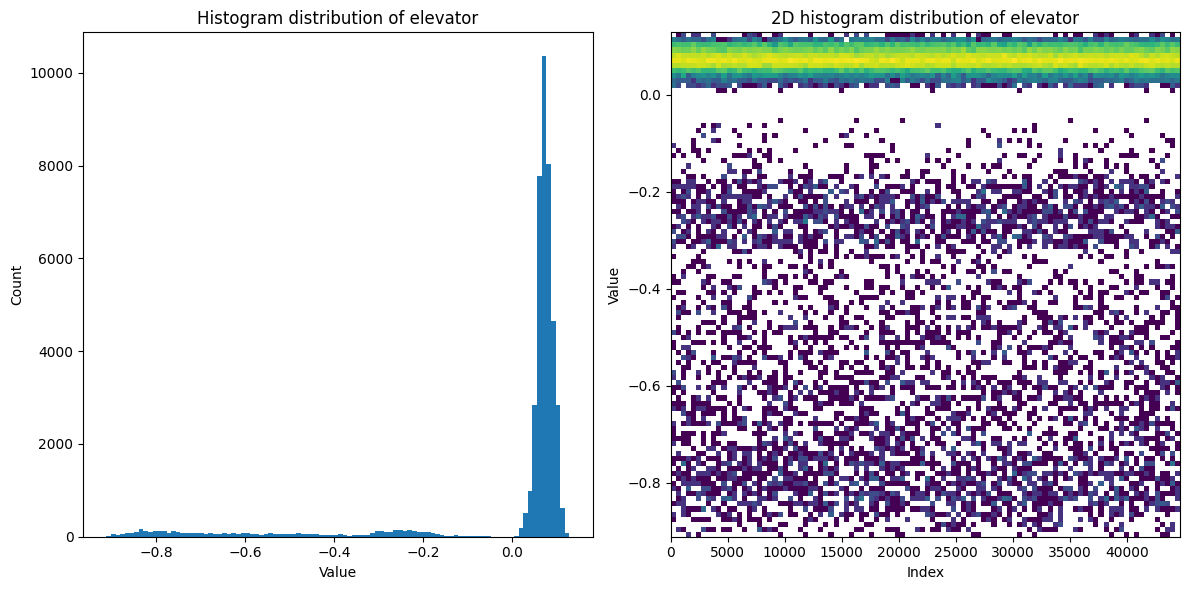

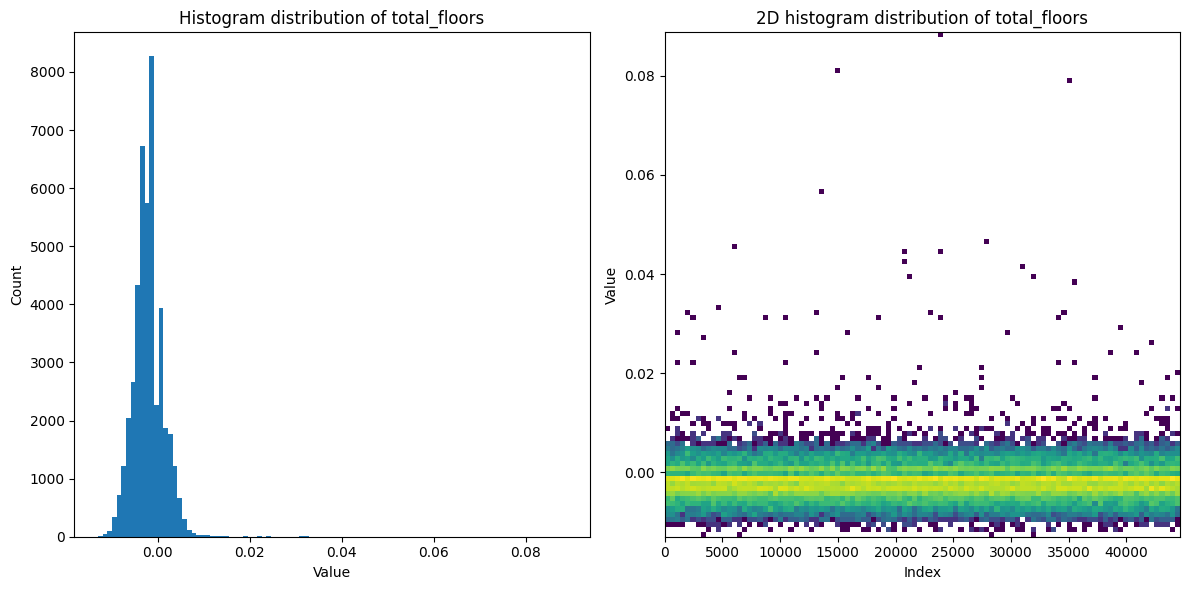

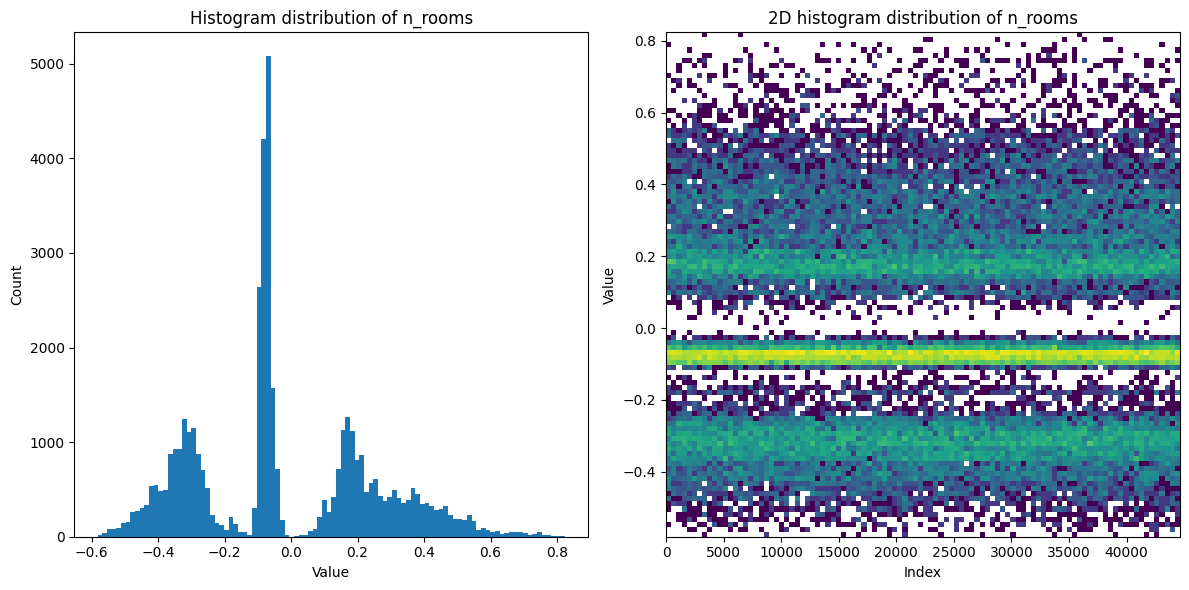

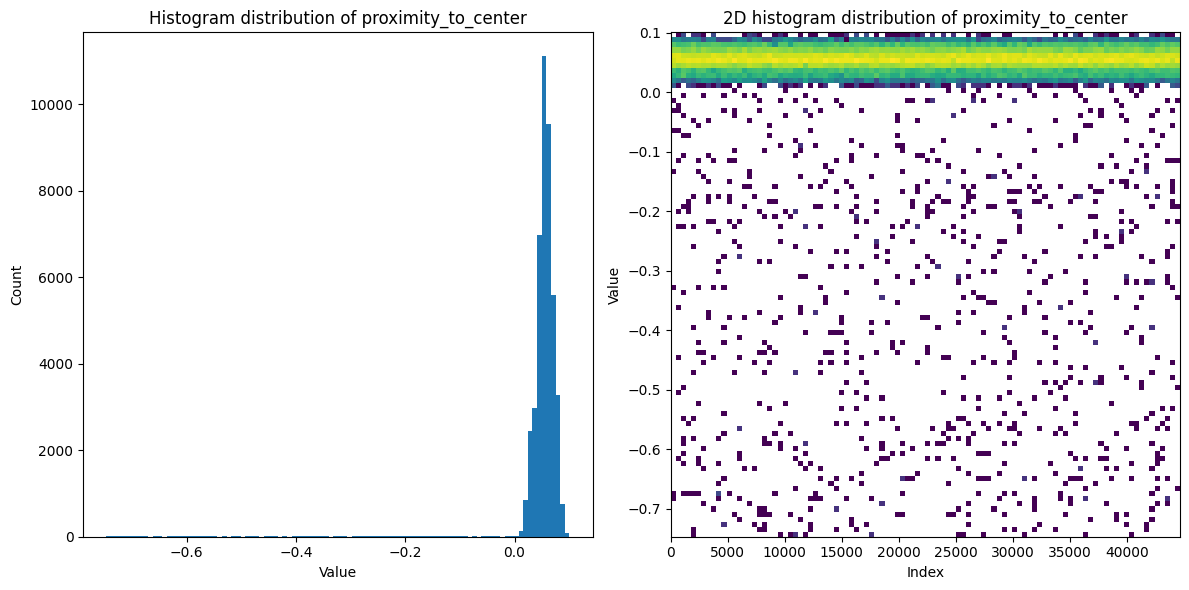

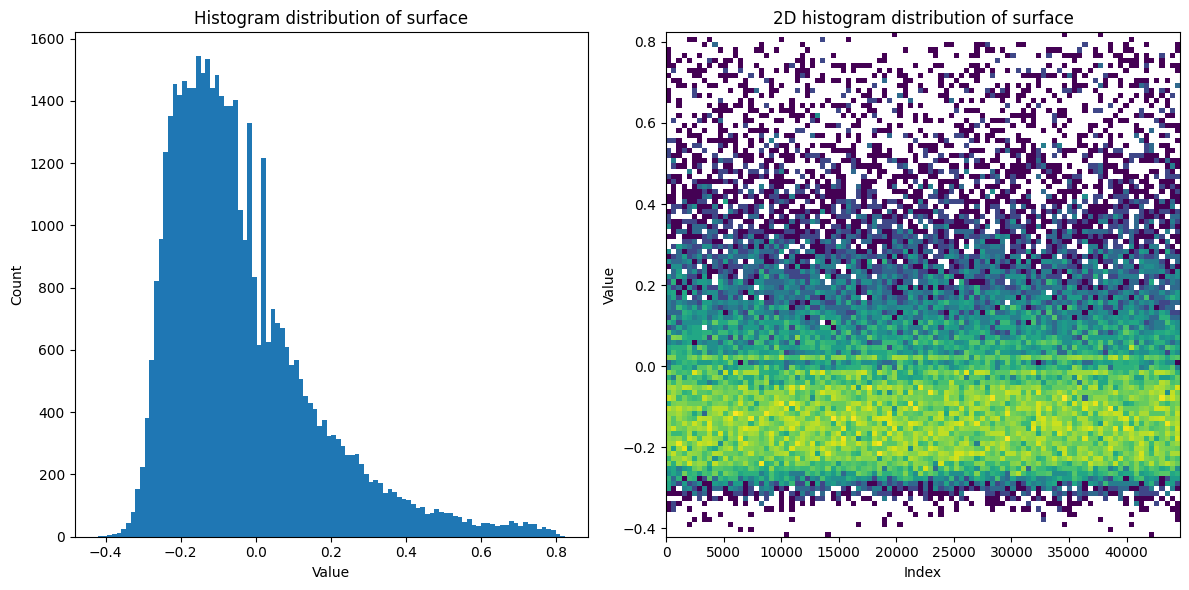

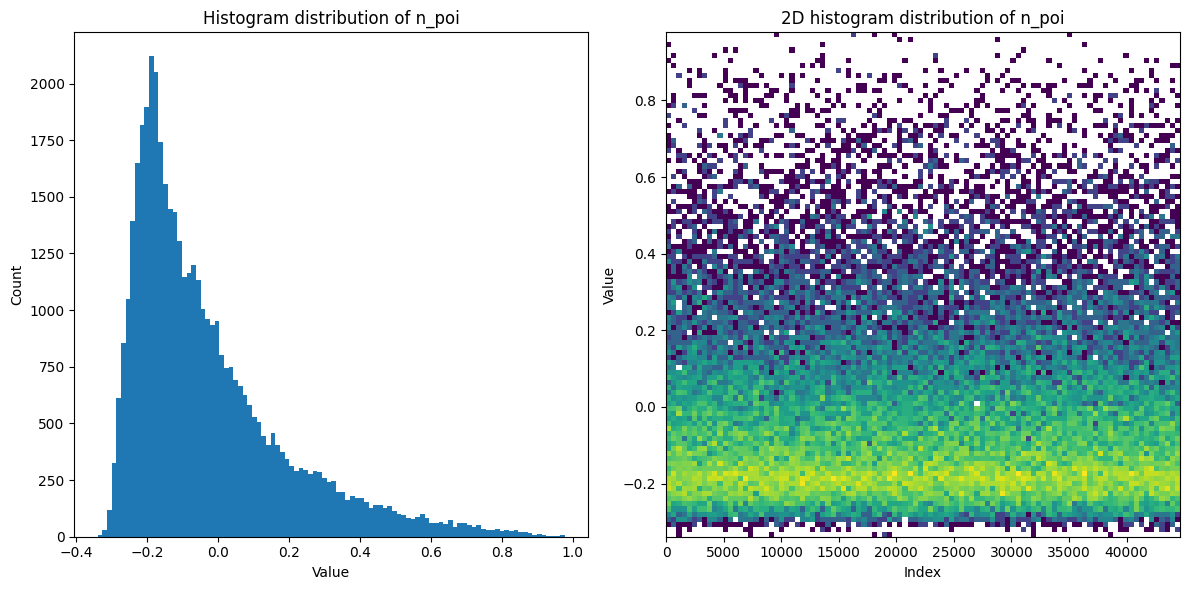

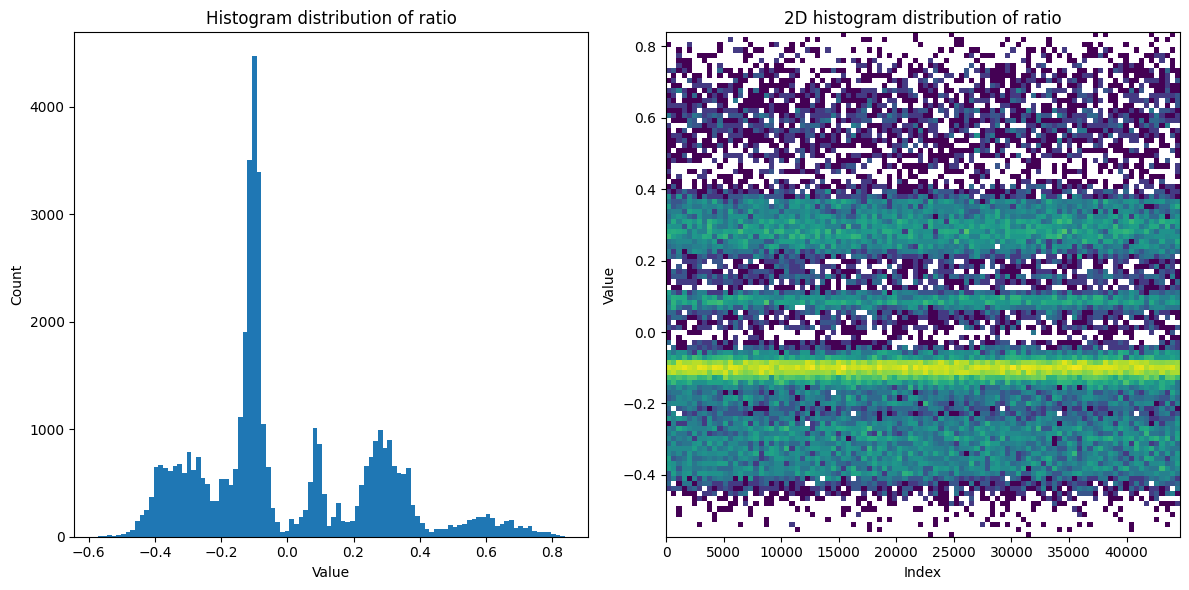

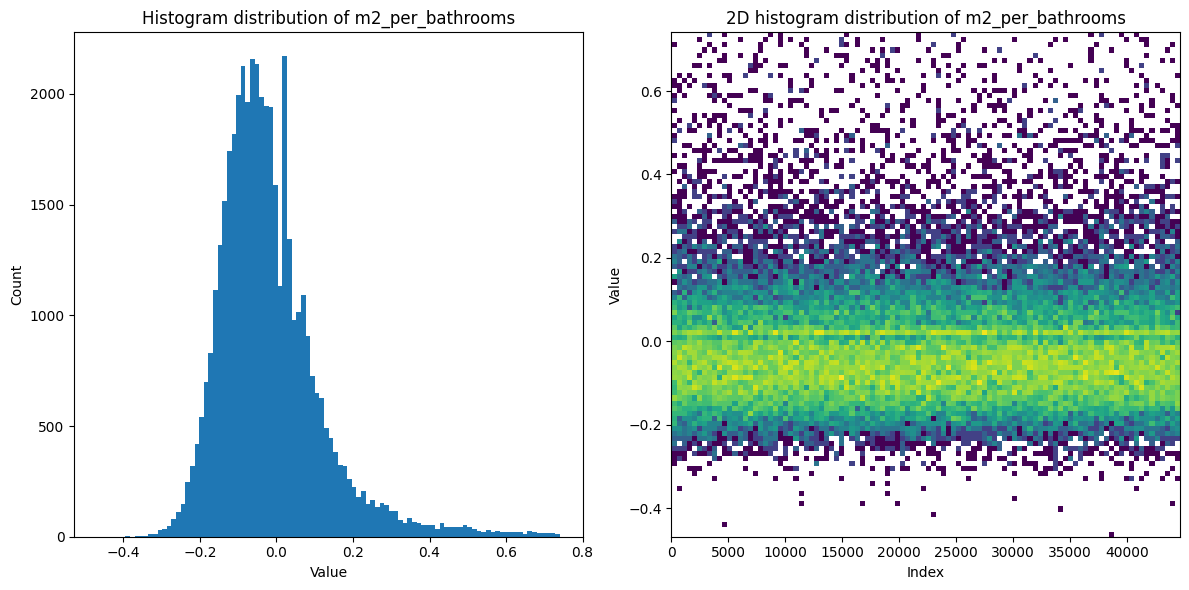

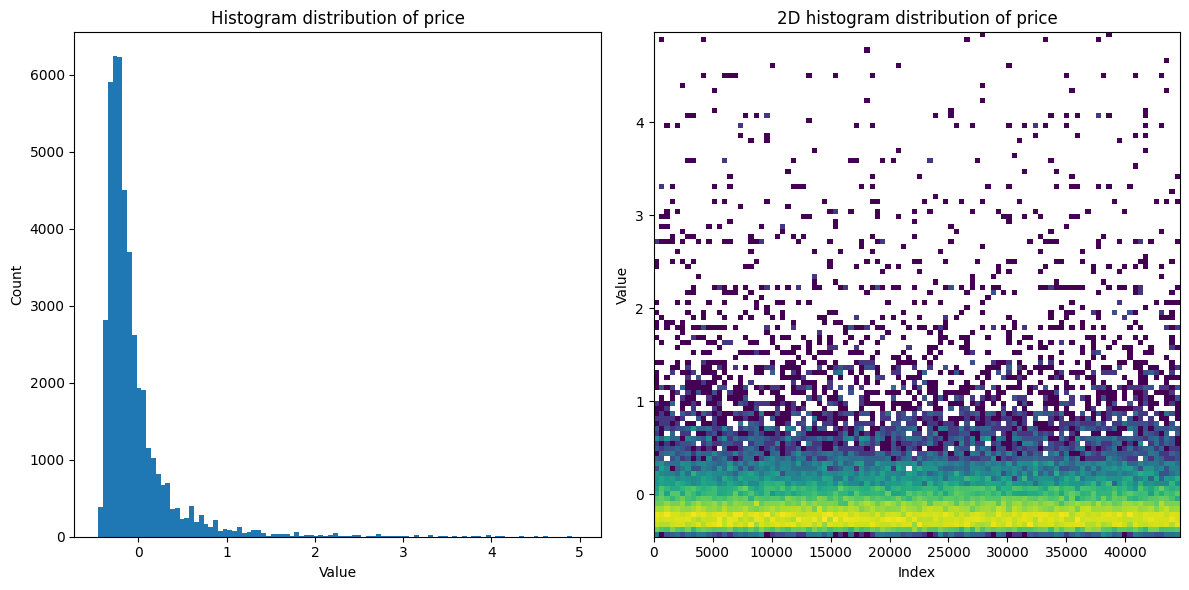

In [61]:
for col in train_df.columns:
    hist_subplot(train_df, col)

separiamo le features dalle prediction per performare nel migliore dei modi: StandardScaler, KNNImputer, Normalizer

In [51]:
x_train = train_df.drop('price', axis=1)
y_train = train_df['price']

In [52]:
# StandardScaler
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
x_train = pd.DataFrame(x_scaler.fit_transform(x_train), columns=x_train.columns)
y_scaler = StandardScaler()
y_train = pd.DataFrame(y_scaler.fit_transform(y_train.values.reshape(-1, 1)), columns=['price'])

In [53]:
from sklearn.impute import KNNImputer
x_imputer = KNNImputer()
x_train = pd.DataFrame(x_imputer.fit_transform(x_train), columns=x_train.columns)

In [54]:
from sklearn.preprocessing import Normalizer
x_normalizer = Normalizer()
x_train = pd.DataFrame(x_normalizer.fit_transform(x_train), columns=x_train.columns)

We run again the NaN analysis to verify that there are no more NaNs in any feature. 

In [ ]:
analysis1, analysis2 = NaN_analysis(train_df)

In [ ]:
analysis1

In [ ]:
analysis2

PLottiamo a fine di tutte le trasformation gli hist di tutte le colonne di train_df

In [ ]:
for col in train_df.columns:
    hist_subplot(train_df, col)

# 2.2. Drop Outliers

Droppiamo abs_z_scores < 5 tramite zscore

In [55]:
train_df = pd.concat([x_train, y_train], axis=1)

In [56]:
original_shape = train_df.shape[0]
z_scores = zscore(train_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 5).all(axis=1)

In [57]:
train_df = train_df[filtered_entries]
new_shape = train_df.shape[0]

In [58]:
print('original shape: {}'.format(original_shape))
print('new shape: {}'.format(new_shape))
print('percentage of rows removed: {}%'.format(((original_shape-new_shape)*100)/original_shape))

original shape: 46312
new shape: 44639
percentage of rows removed: 3.612454655380895%


At the end of the trasformations we plot histograms for all train_df columns

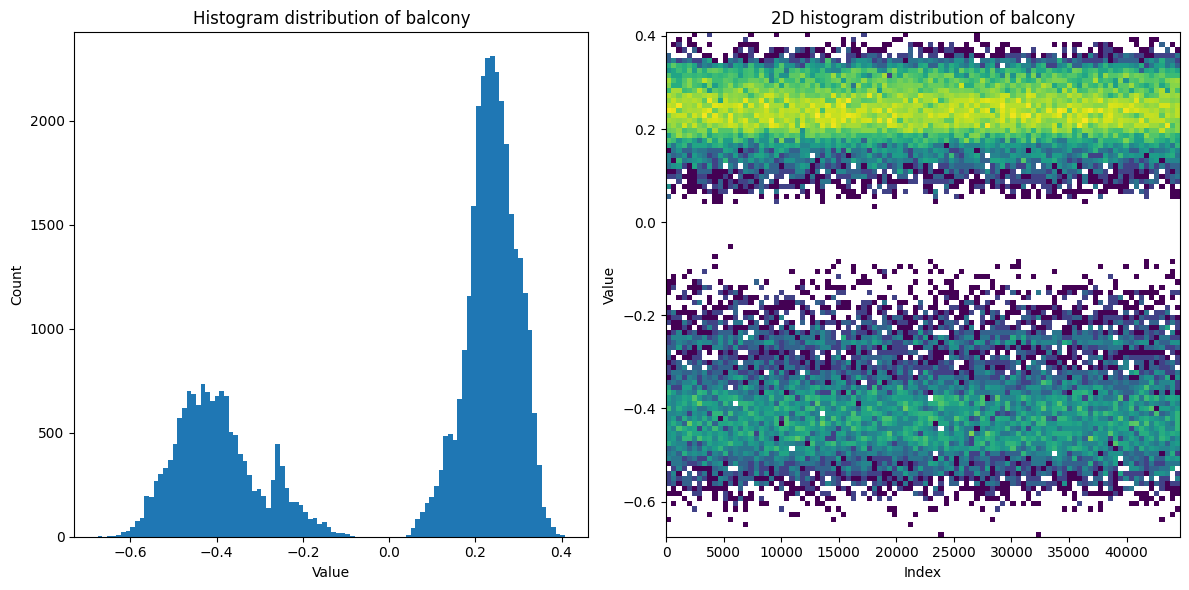

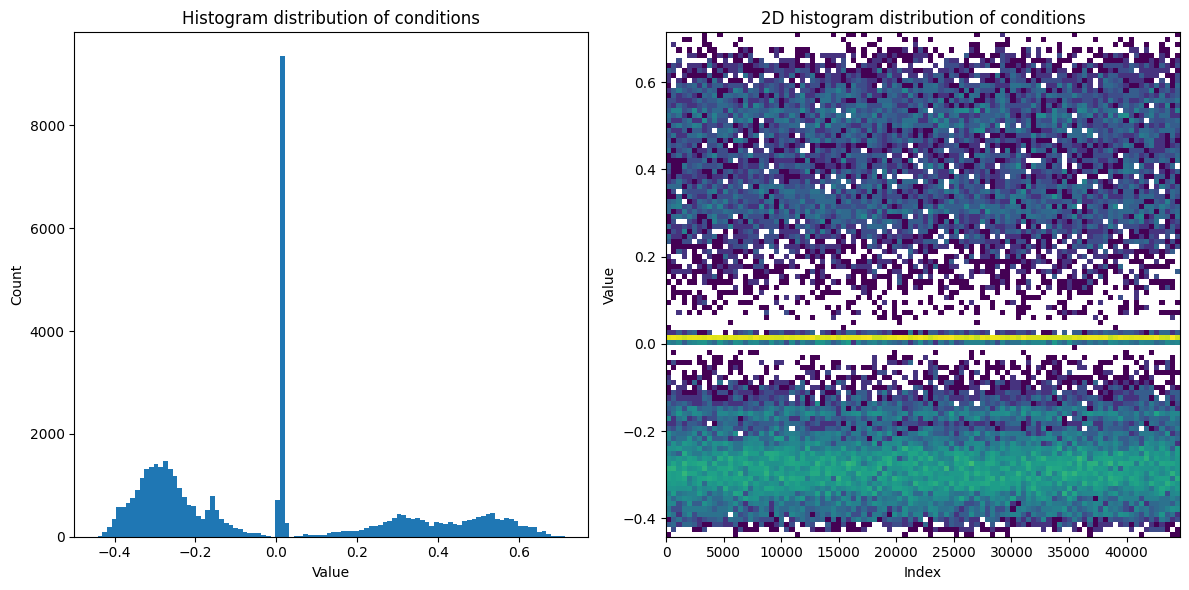

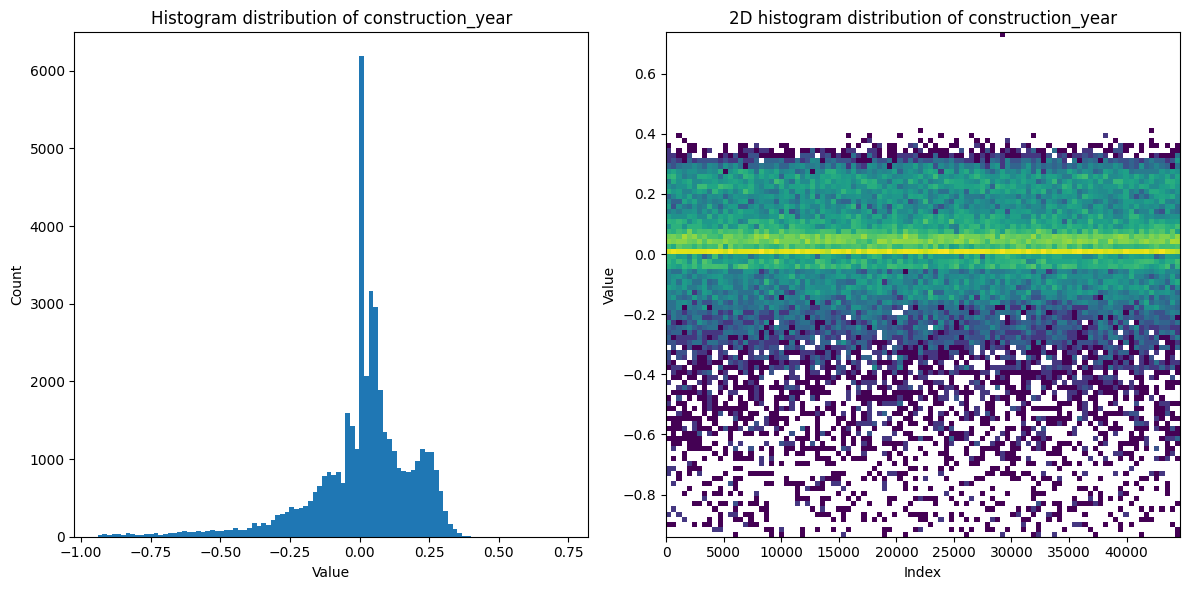

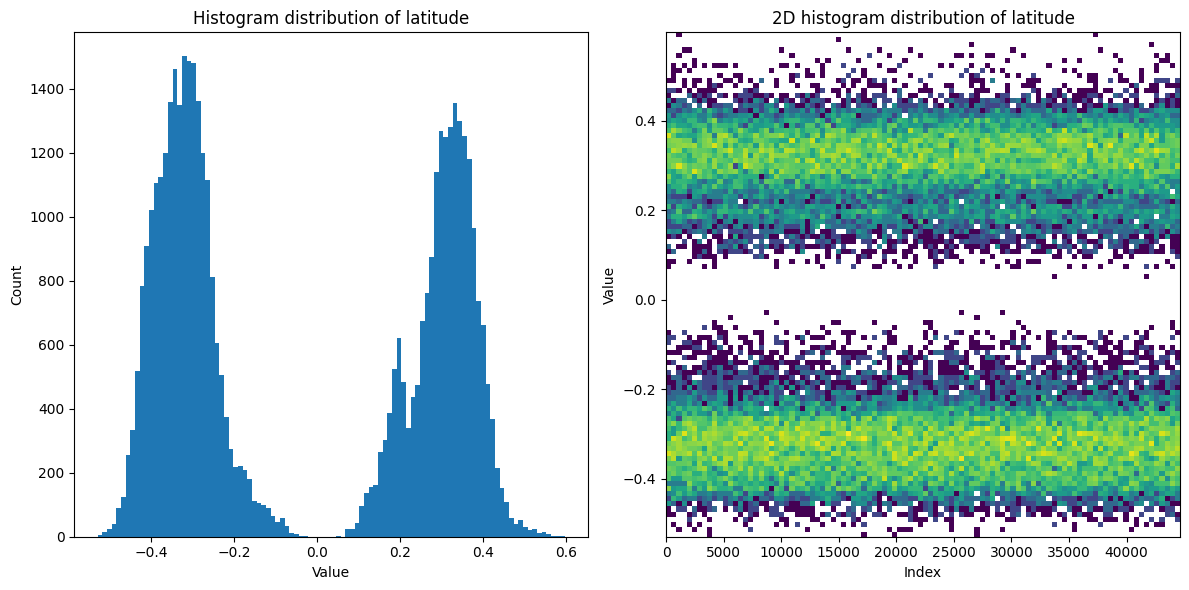

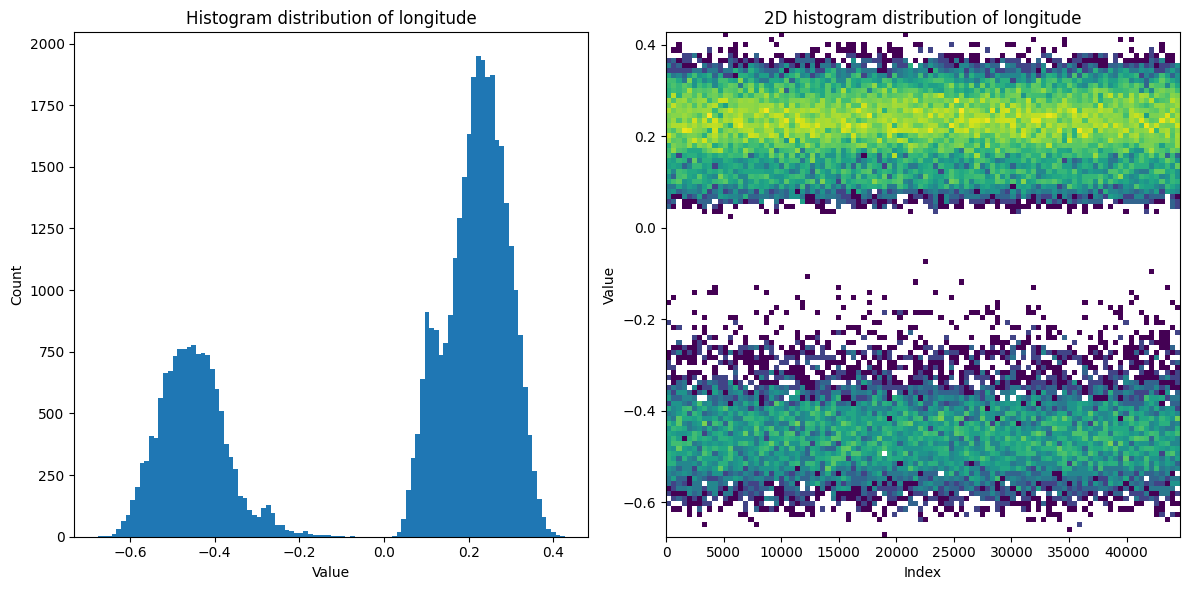

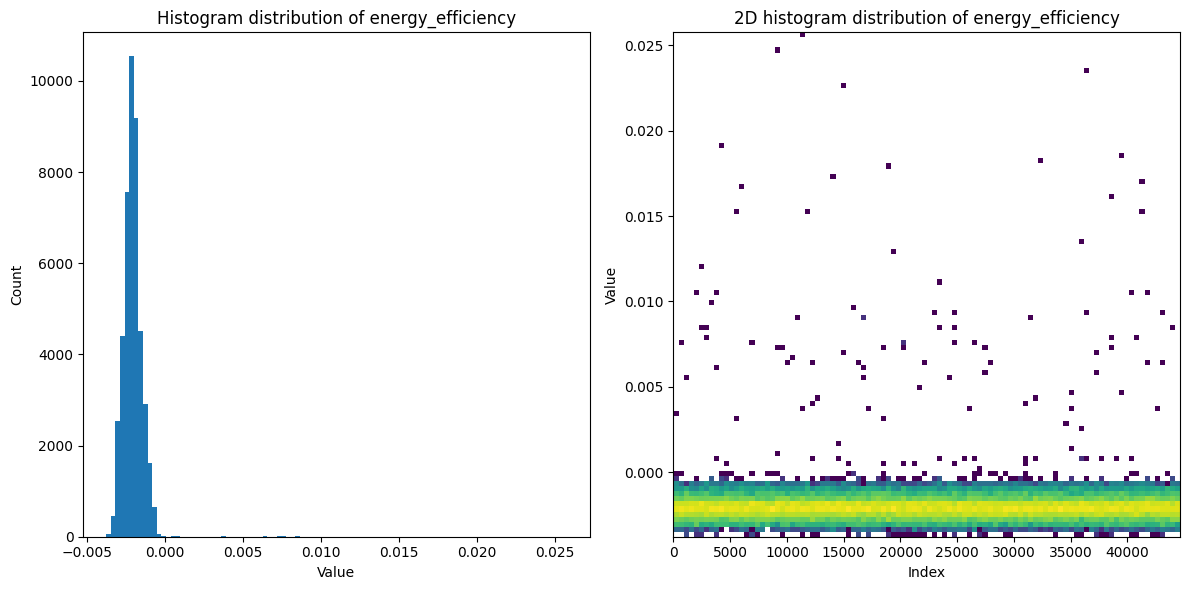

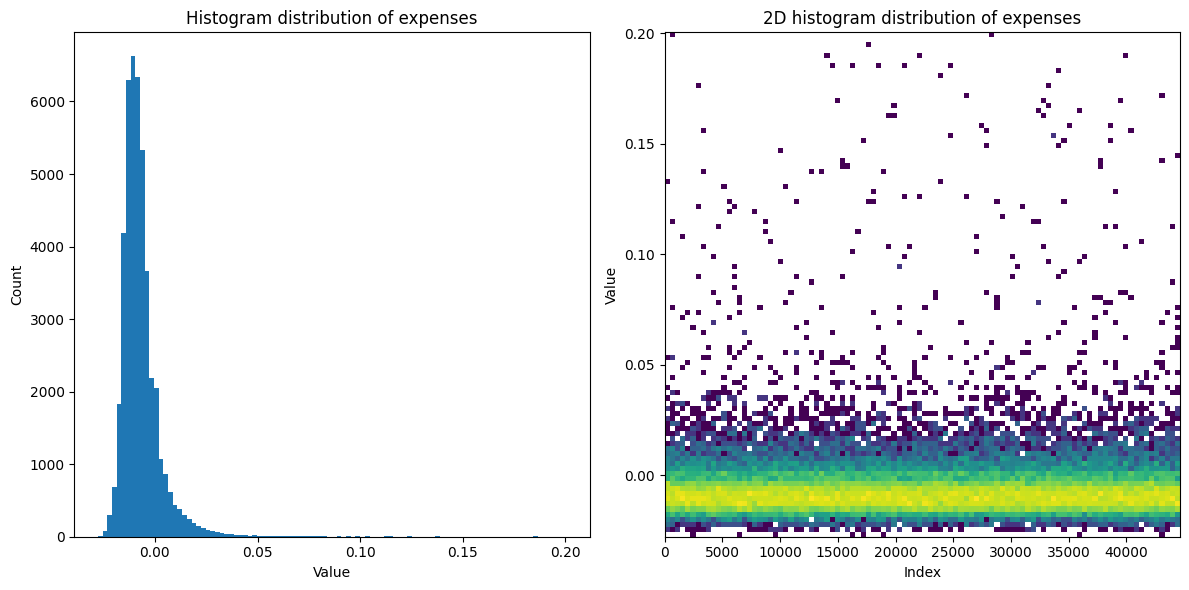

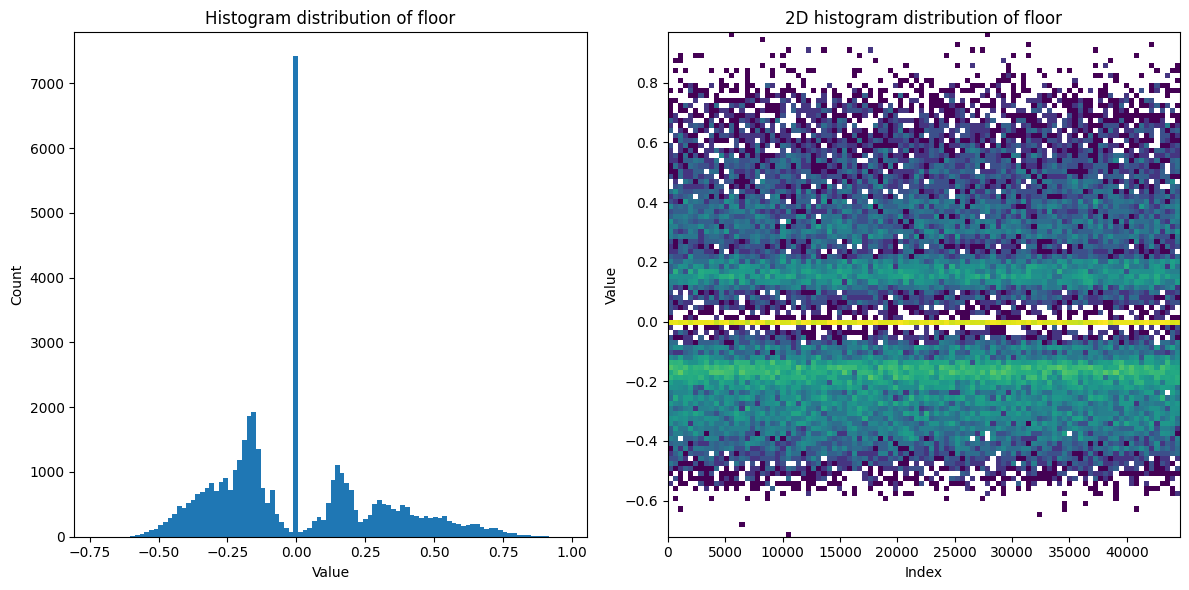

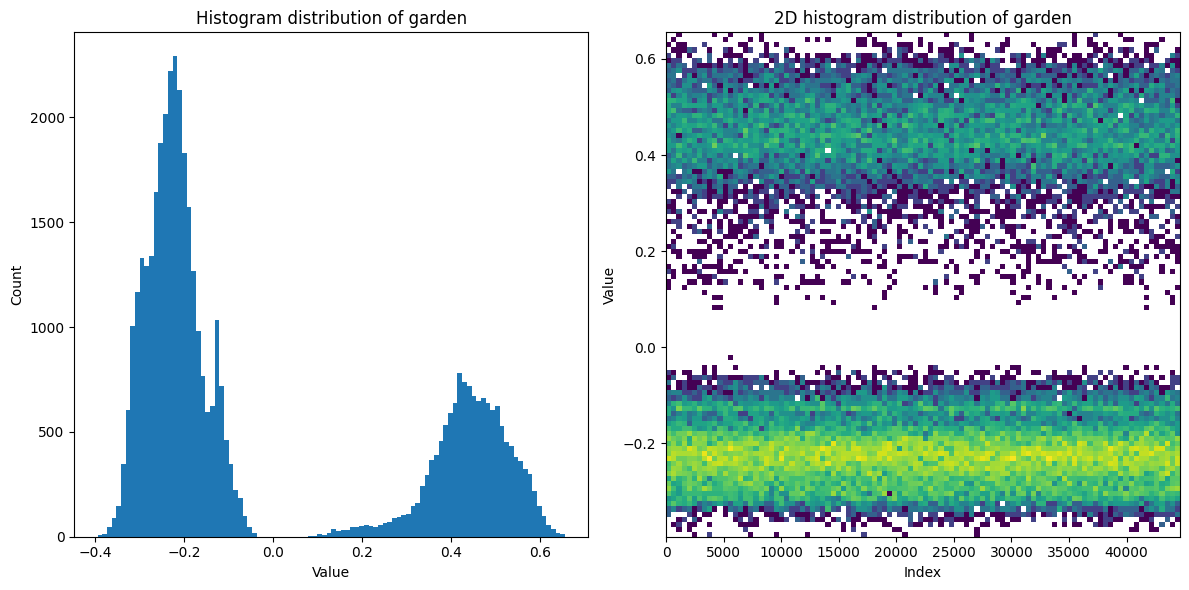

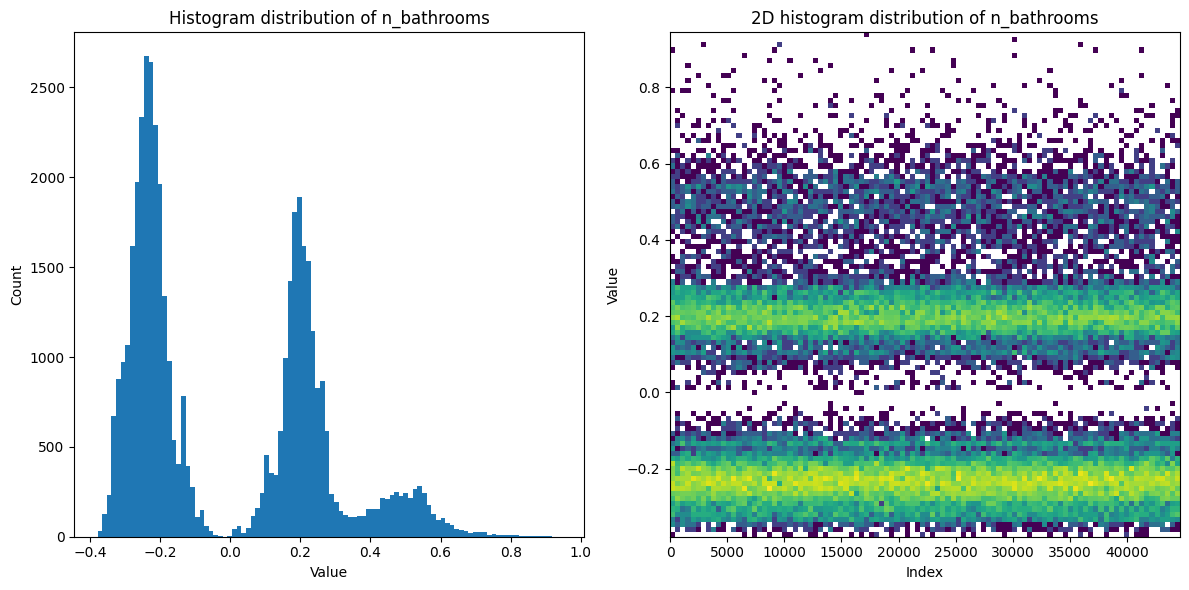

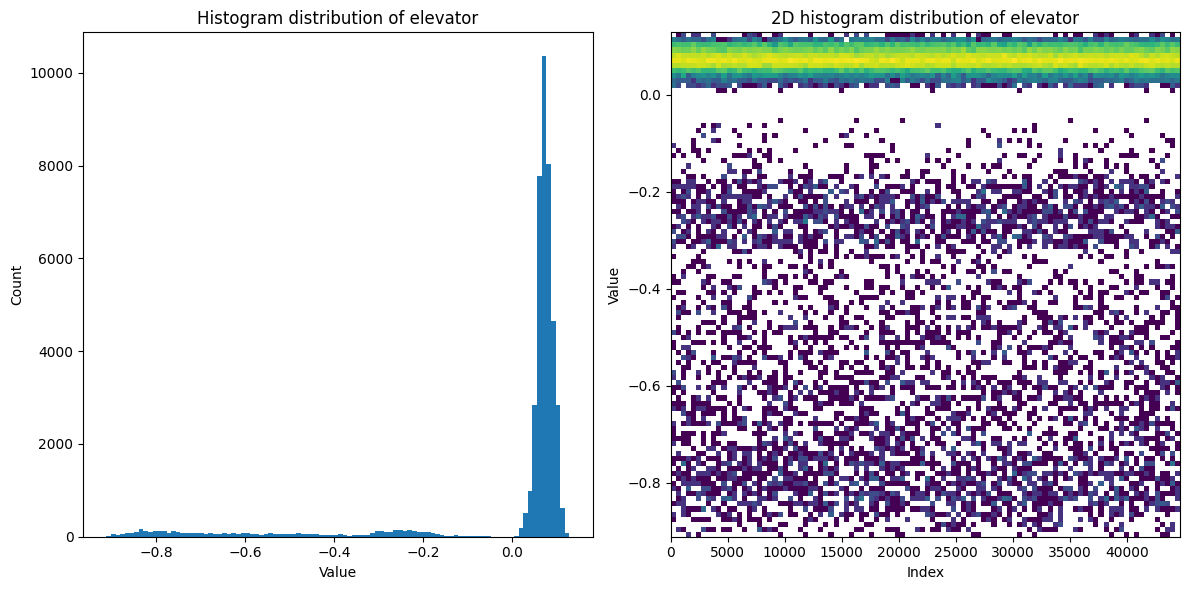

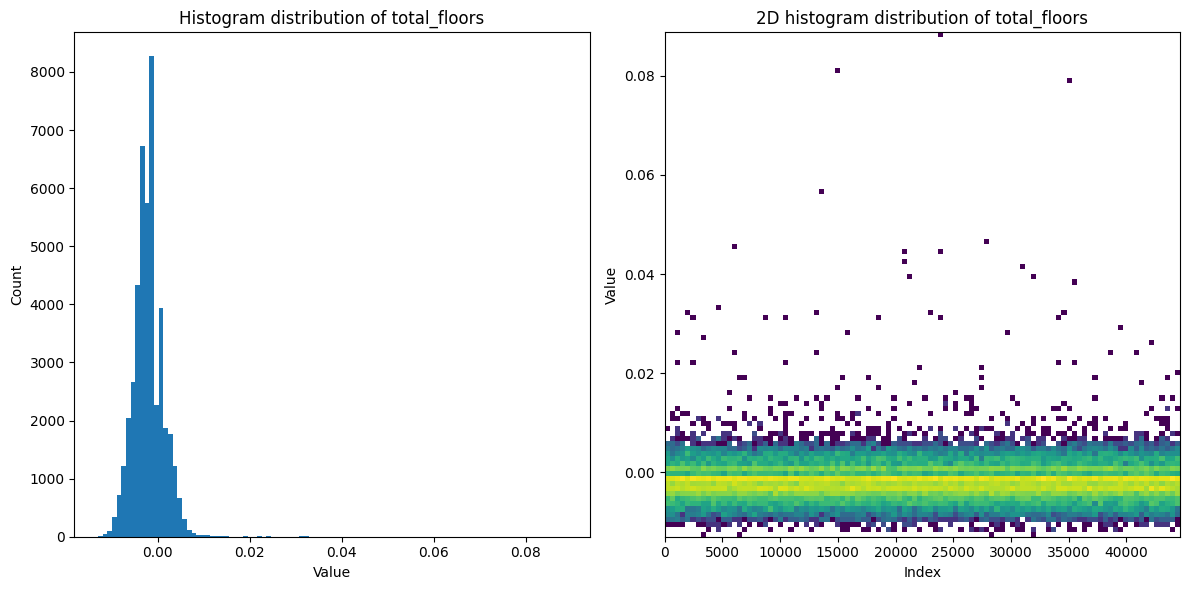

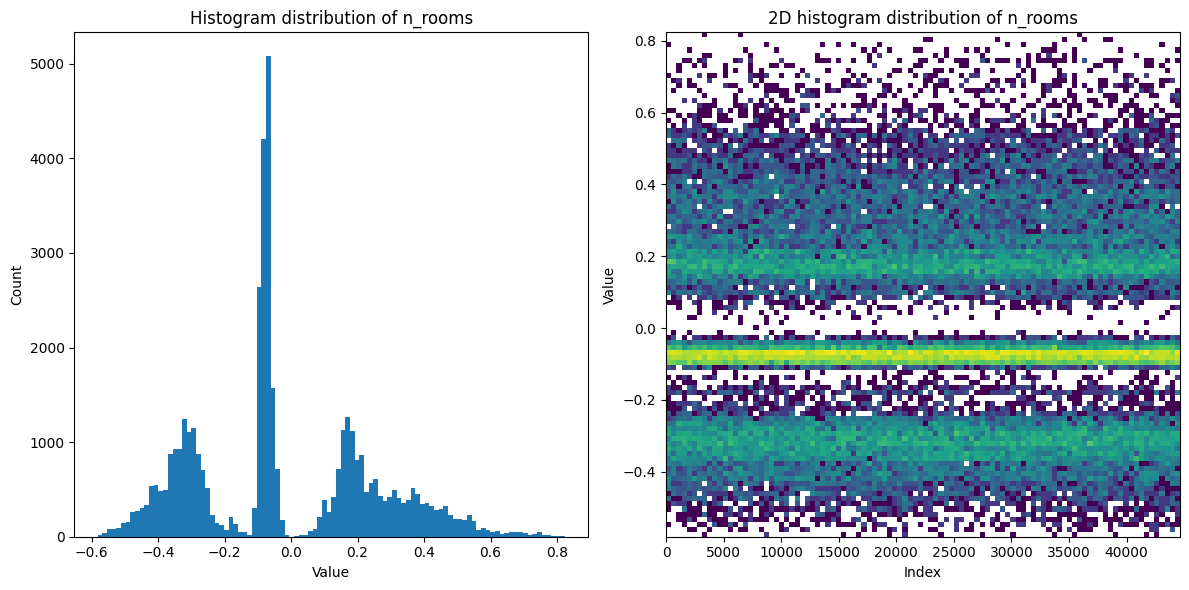

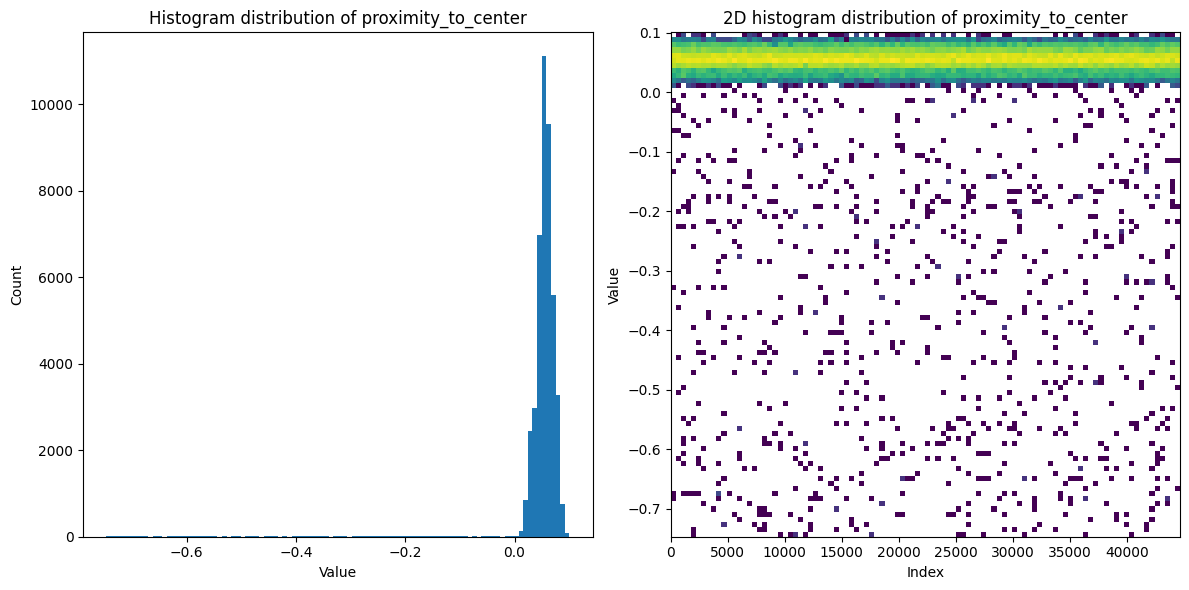

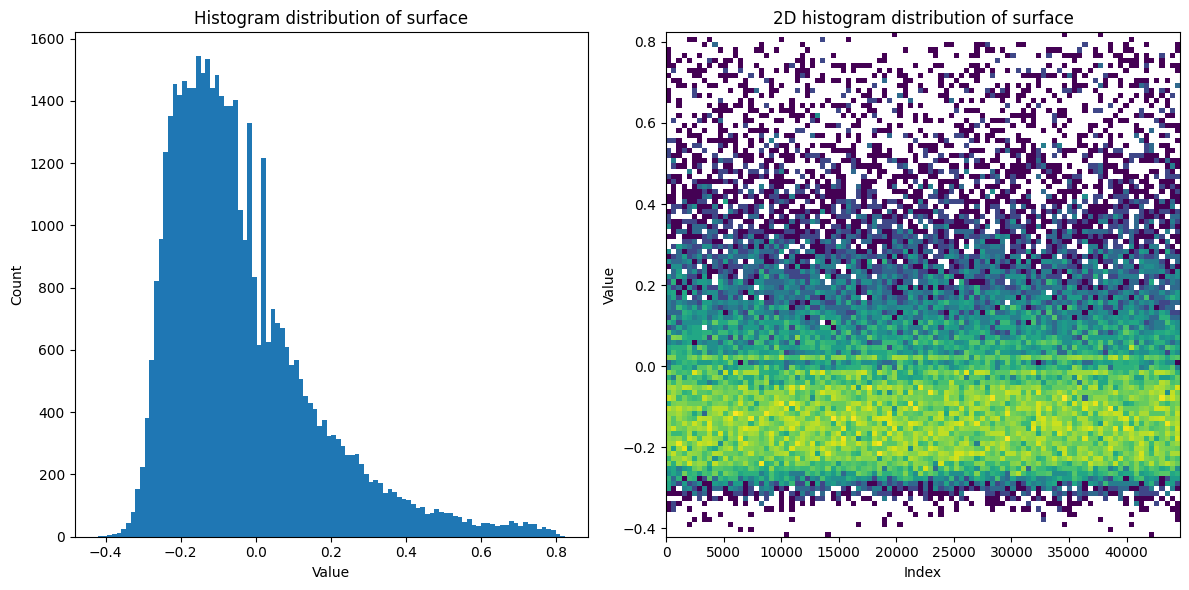

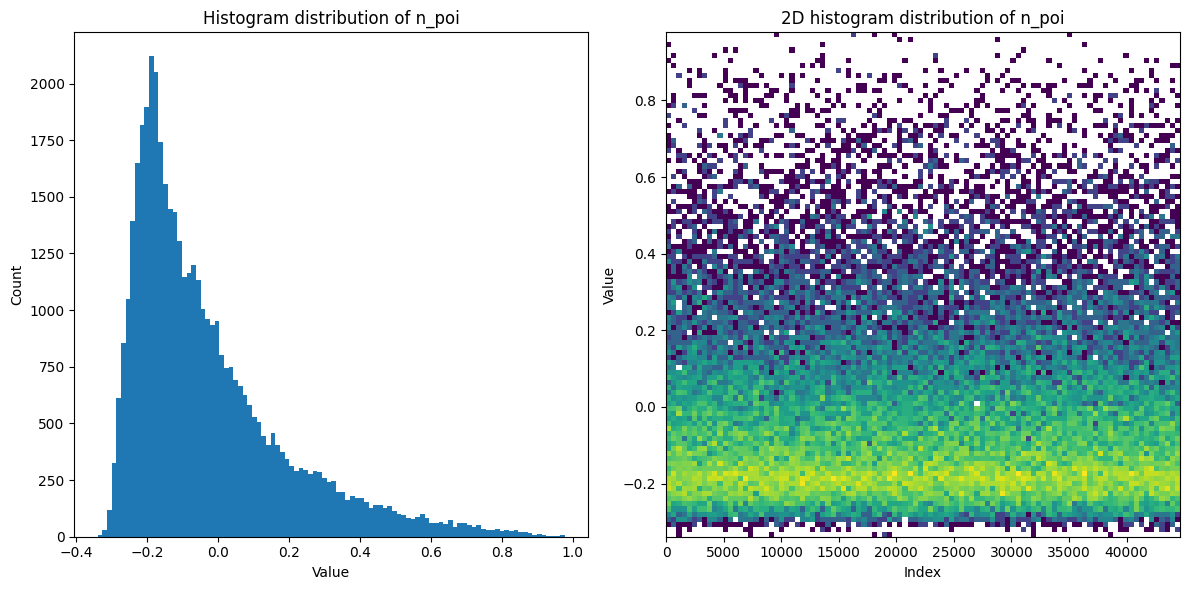

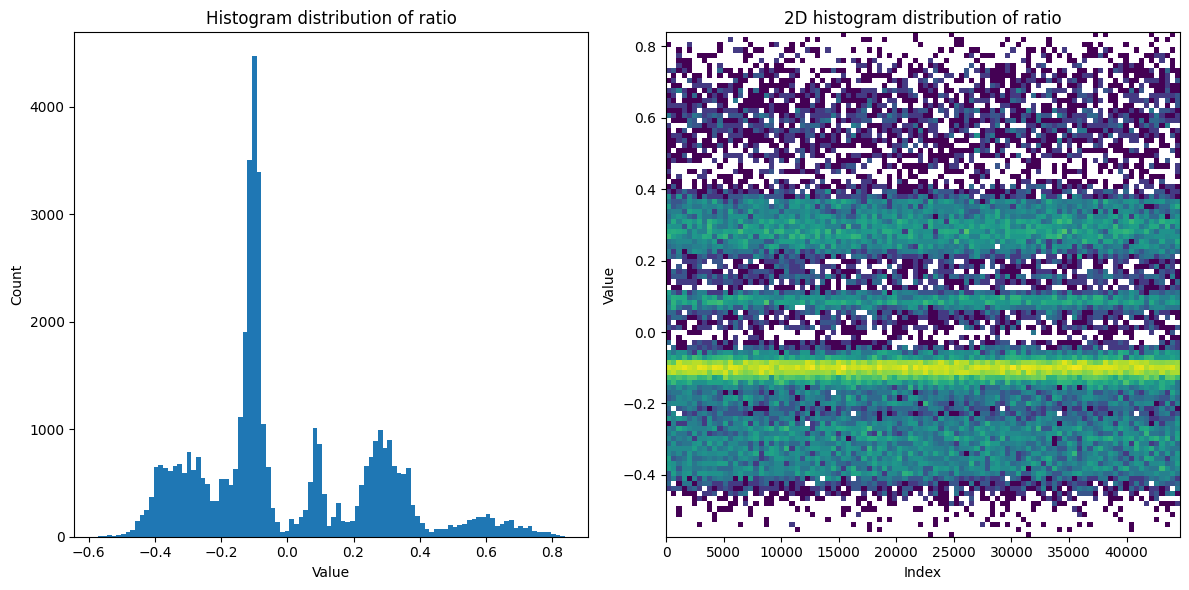

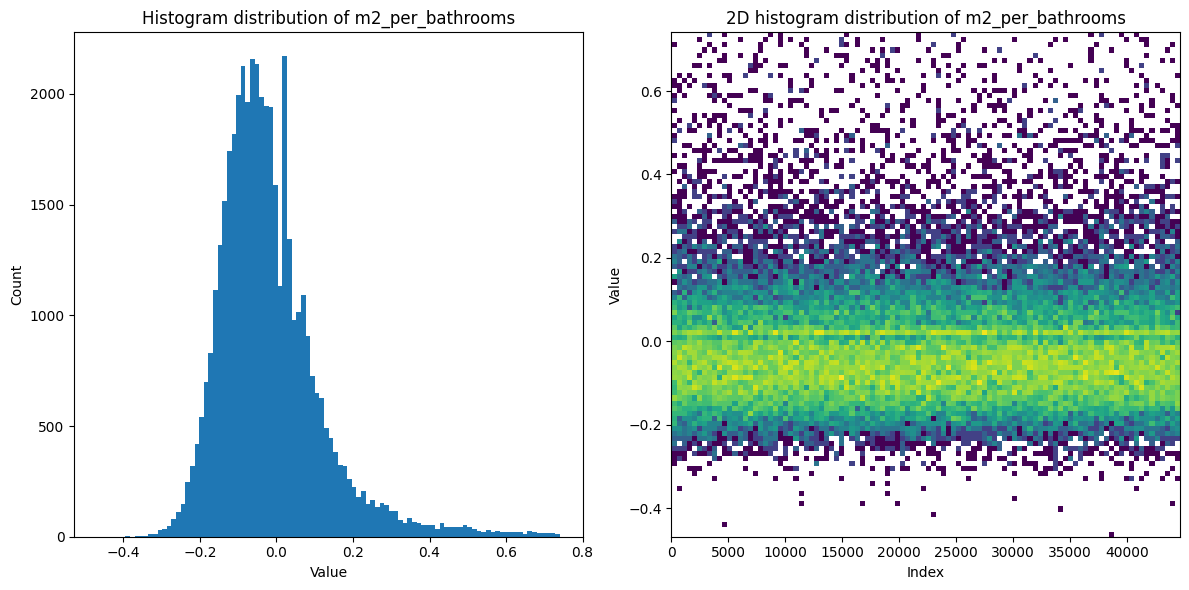

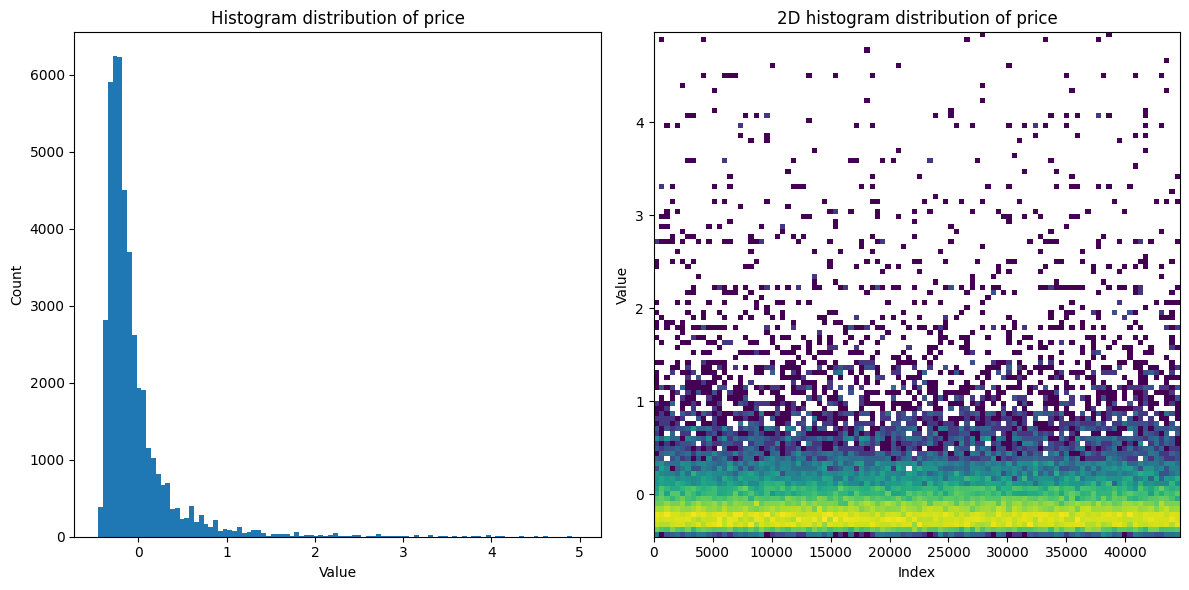

In [59]:
for col in train_df.columns:
    hist_subplot(train_df, col)

# 2.3. Feature Importance Analysis

PLottiamo la correlation matrix

<Axes: >

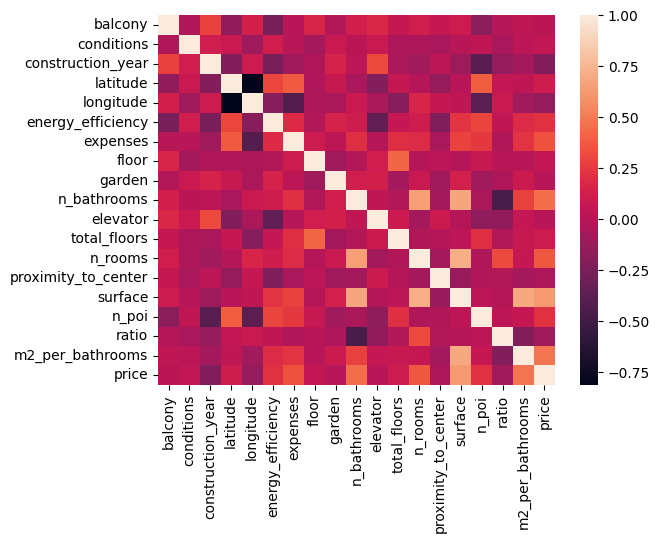

In [60]:
sns.heatmap(train_df.corr())

Performiamo la feature importance analisys im modo da capire quanto ogni feature è utile all'apprendimento

In [ ]:
x_train = train_df.drop('price', axis=1)
y_train = train_df['price']

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# compute feature_importances
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(x_train, y_train)
sorted(rf.feature_importances_, reverse=True)

In [ ]:
# plot feature_importances
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])

# 4. Training

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'MLPRegressor': MLPRegressor(),
    'SVR': SVR()
}

In [ ]:
for model_name, model in models.items():
    print('model: {}'.format(model_name))
    model.fit(x_train, y_train)

# 5. Evaluation

In [ ]:
from sklearn.model_selection import cross_val_score
def evaluate_model(model, x, y, y_scaler, scoring='neg_mean_squared_error'):
    scores = cross_val_score(model, x, y, cv=5, scoring=scoring)
    print('scores: {}'.format(scores))
    print('mean: {}'.format(-scores.mean()))
    print('std: {}'.format(scores.std()))
    # plot scatter plot of y_pred vs y_true
    y_pred = y_scaler.inverse_transform(model.predict(x).reshape(-1, 1))
    y = y_scaler.inverse_transform(y.values.reshape(-1, 1))
    plt.scatter(y, y_pred)
    plt.plot([0, max(y.max(), y_pred.max())], [0, max(y.max(), y_pred.max())], 'r--', lw=2)
    plt.title('{}'.format(model))
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    plt.show()
    plt.close()
    return scores

In [ ]:
performance = {model_name: {'MSE_mean': 0.0, 'MSE_std': 0.0} for model_name in models.keys()}

In [ ]:
for model_name, model in models.items():
    print('model: {}'.format(model_name))
    MSE_scores = evaluate_model(model, x_train, y_train, y_scaler, scoring='neg_mean_squared_error')
    performance[model_name]['MSE_mean'] = -MSE_scores.mean()
    performance[model_name]['MSE_std'] = MSE_scores.std()

In [ ]:
performance_df = pd.DataFrame.from_dict(performance, orient='index').sort_values(by='MSE_mean').reset_index().rename(columns={'index': 'model'})
performance_df

# 6. Submission

In [ ]:
def x_test_preprocessing(x_test, poi_df, map_conditions, x_scaler, x_imputer, x_normalizer):
    x_test['n_poi'] = x_test.apply(lambda x: get_n_poi(x['latitude'], x['longitude'], poi_df), axis=1)
    x_test['ratio'] = x_test.apply(lambda x: lambda_ratio(x), axis=1)
    x_test['m2_per_bathrooms'] = x_test.apply(lambda x: lambda_m2_per_bathrooms(x), axis=1)
    x_test['garden'] = x_test['garden'].fillna(False)
    x_test['balcony'] = x_test['balcony'].fillna(False)
    x_test['garden'] = x_test['garden'].apply(lambda x: 1 if x == True else 0)
    x_test['balcony'] = x_test['balcony'].apply(lambda x: 1 if x == True else 0)
    x_test['conditions'] = x_test['conditions'].apply(lambda x: map_conditions[x])
    x_test['conditions'] = x_test['conditions'].apply(lambda x: np.nan if x == map_conditions[np.nan] else x)
    x_test = pd.DataFrame(x_scaler.transform(x_test), columns=x_test.columns)
    x_test = pd.DataFrame(x_imputer.transform(x_test), columns=x_test.columns)
    x_test = pd.DataFrame(x_normalizer.transform(x_test), columns=x_test.columns)
    return x_test

In [ ]:
test_id = test_df['id']
x_test = test_df.drop('id', axis=1)
x_test = x_test_preprocessing(x_test, poi_df, map_conditions, x_scaler, x_imputer, x_normalizer)

In [ ]:
def submission(model, filename, x_test, y_scaler):
    y_pred = y_scaler.inverse_transform(model.predict(x_test).reshape(-1, 1))
    y_pred = pd.DataFrame(y_pred, columns=['price'])
    submission_df = pd.concat([test_id, y_pred], axis=1)
    submission_df.to_csv(filename, index=False)
    return

In [ ]:
for model_name, model in models.items():
    submission(model, 'submission/{}.csv'.format(model_name), x_test, y_scaler)

# 7. Tuning

- troviamo la combinazione di iperparametri migliori per il modello migliore che abbiamo fino ad ora ottenuto
- quindi accordiamo il modello migliore

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [None, 10, 15],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)

In [ ]:
best_params = grid_search.best_params_
best_params

In [ ]:
tuned_model = RandomForestRegressor(**best_params)
tuned_model.fit(x_train, y_train)
MSE_score = evaluate_model(tuned_model, x_train, y_train, y_scaler, scoring='neg_mean_squared_error')
print('MSE: {:.3f} ({:.3f} std)'.format(-MSE_score.mean(), MSE_score.std()))

In [ ]:
submission(tuned_model, 'submission/tuned_model.csv', x_test, y_scaler)